# Analysis of Unspliced Reads

In [31]:
from datetime import date
print('created 2024-05-06')
print("last updated", date.today())

created 2024-05-06
last updated 2024-06-06


In this notebook I will examine the reads which were flagged as GFP unspliced. 

Each read is first parsed by its index into which sample it came from. Then the first 6nt at the 5' end are compared to the expected sequence for GFP or dTomato (marked by ^). If the first 6nt match either reporter with ≤1 mismatch, that read is called GFP or dTomato, otherwise it is discarded. If the read is classified as GFP I then examine bases 19-26, which I expect to be downstream of the exon-exon junction (marked with ||). I compare these to the expected sequence of the spliced mRNA (marked by *). If the sequence does not match with ≤1 error the read is classified as unspliced.

```html
  spliced: TGATCGTCGTCACCAG||GTGTCGTGAAHHHHHHHHHH...
unspliced: TGATCGTCGTCACCAG  gtgagtagcgggnnnnnnnn...
  dTomato: GCTAGCTCGTGATTCAG GTGTCGTGAAHHHHHHHHHH...
           ^^^^^^               *******


In [32]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import colors

from scipy import stats
from scipy.stats import spearmanr
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 200

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'
IME_path = outpath+'../../Cluster/IME/'

In [33]:
# load in barcode-to-intron dictionary from round 2 (bottlenecked)
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters.pkl', 'rb') as f:
    b2i_06 = pickle.load(f)

# load in list of barcodes deemed trustworthy by mismatch analysis
with open(outpath+'pkls/06_4_barcodes_with_less_than_10_percent_reads_mismatched_v3_min3readclusters.pkl', 'rb') as f:
    bcs_to_keep = pickle.load(f)

# final b2i contains trustworthy barcodes only
b2i = {b:b2i_06[b] for (mismatch_rate, b) in bcs_to_keep}

In [34]:
# load in unspliced reads
RIL2_unspliced_dicts = {f'{c}_{i}':{} for c in ['canonical','cryptic'] for i in [1,2]}

for i in [1,2]:
    for c in ['canonical','cryptic']:
        with open(outpath+f'data/reads/RIL2_{i}_{c}_unspliced_dict_both_reads.pkl', 'rb') as f:
            RIL2_unspliced_dicts[f'{c}_{i}'] = pickle.load(f)

# merge into one dict to analyze all together
RIL2_unspliced_merge = {b:[] for b in b2i}

for R_dict in RIL2_unspliced_dicts.values():
    for b in R_dict:
        if b in b2i:
            RIL2_unspliced_merge[b].append(R_dict[b])

for b in b2i:
    if len(RIL2_unspliced_merge[b])==0:
        del RIL2_unspliced_merge[b]
    else:
        RIL2_unspliced_merge[b] = flatten(RIL2_unspliced_merge[b])
        
# how many barcodes are there here?
len(RIL2_unspliced_merge)

12048

In [35]:
# how many reads are there?
len(flatten([x for x in RIL2_unspliced_merge.values()]))

1276616

# validation of barcode-intron mapping via unspliced reads

a mismapped intron will have the expected constant 5'SS and 3'SS sequence, but different than expected sequence in the variable region. we can split each read into 6 regions and get the lev dist observed/expected for each in order to specifically highlight reads that map in the constant region and not the variable region.

In [36]:
# generate a list of tuples representing the lev distance between observed and expected seq
# for each reverse (5' end of amplicon) and forward (3' end, must take reverse complement) read pair

lengths = [16, 12, 16, 4, 40, 10]
RIL2_unspliced_errors = {b:[] for b in RIL2_unspliced_merge}
RIL2_unspliced = {b:[] for b in RIL2_unspliced_merge}
exon1 = 'TGATCGTCGTCACCAG'
fiveSS_seq = 'GTGAGTAGCGGG'
threeSS_seq = 'GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG'
exon2 = 'GTGTCGTGAA' 
actually_spliced = []

for bc, reads in RIL2_unspliced_merge.items():
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    for read in reads:
        fread = read[0]
        rread = read[1]
        exon1_score = lev(rread[:16], exon1)
        SS_score5 = lev(rread[16:28], fiveSS_seq)
        dist5 = lev(rread[28:], expected_5end)
        dist3 = lev(rc(fread)[:4], expected_3end)
        SS_score_3 = lev(rc(fread)[4:44], threeSS_seq)
        exon2_score = lev(rc(fread)[44:54], exon2)
        maybe_spliced = lev(rread[16:28], exon2+bc[:2])
        if maybe_spliced <=2:
            actually_spliced.append(bc)
        else:
            RIL2_unspliced_errors[bc].append([exon1_score,SS_score5,dist5,dist3,SS_score_3,exon2_score])
            RIL2_unspliced[bc].append(read)

In [37]:
for bc in list(RIL2_unspliced_merge.keys()):
    if len(RIL2_unspliced[bc]) == 0:
        del RIL2_unspliced[bc]
    if len(RIL2_unspliced_errors[bc]) == 0:
        del RIL2_unspliced_errors[bc]

In [38]:
# how many reads were, in fact, probably correctly spliced?
print(len(actually_spliced))

76602


In [39]:
# how many barcodes are there now?
len(RIL2_unspliced)

11934

In [40]:
# how many reads are there now?
len(flatten([x for x in RIL2_unspliced.values()]))

1200014

In [41]:
# first ask: what is the sequencing error rate that we expect 
# from looking at exonic sequence?

exon_error_rates = []
for bc, read_errors in RIL2_unspliced_errors.items():
    exon_error_rates.append([e[0]/16 for e in read_errors])    # exon 1
    exon_error_rates.append([e[5]/10 for e in read_errors])    # exon 2
exon_error_rates = np.array(flatten(exon_error_rates))

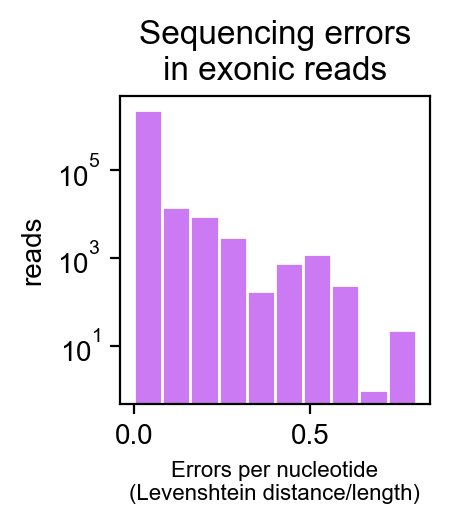

mean: 0.0027
99th percentile: 0.1, or 1 in 10.0


In [42]:
hist_data = exon_error_rates
plt.figure(figsize=(2,2))
plt.hist(hist_data, #bins=20,  
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('Errors per nucleotide\n(Levenshtein distance/length)', fontsize=8)
plt.ylabel('reads')
plt.title('Sequencing errors\nin exonic reads')
plt.yscale('log')
plt.show()

# what is the mean error rate?
print(f'mean: {exon_error_rates.mean():.4f}')

# what is the 99th percentile error count?
perc_99 = np.percentile(exon_error_rates, 99)
print(f'99th percentile: {perc_99}, or 1 in {1/perc_99}')

We will use this as the maximum acceptable error to call a sequence "correct" or "expected".

With this threshold, how many reads have the correct constant regions, but incorrect variable regions? 

In [43]:
lengths = [16, 12, 16, 4, 40, 10]
max_errs = [round(n*perc_99) for n in lengths]
max_errs

[2, 1, 2, 0, 4, 1]

In [44]:
RIL2_correct_SS_intron_dists = {bc:[] for bc in RIL2_unspliced_errors}

for bc, reads in RIL2_unspliced_errors.items():
    for i, read in enumerate(reads):
       if read[1]<=max_errs[1] & read[4]<=max_errs[4]:
           RIL2_correct_SS_intron_dists[bc].append((read[2],read[3]))
    if len(RIL2_correct_SS_intron_dists[bc])==0:
        del RIL2_correct_SS_intron_dists[bc]

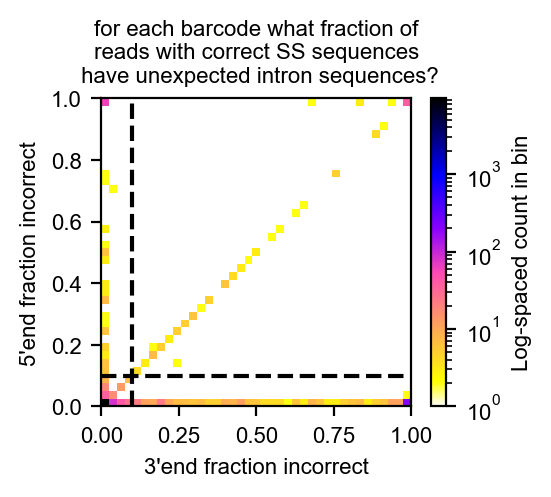

In [220]:
# set max error tolerances for calling read a match
# then compute fraction of matching reads per barcode

tol5 = max_errs[2]
tol3 = max_errs[3]

#data = np.array(flatten(RIL2_correct_SS_intron_dists.values()))

dlists = list(RIL2_correct_SS_intron_dists.items())
bcs = [bc for bc,dlist in dlists]
data = np.array([(np.sum([d[0]>tol5 for d in dlist])/len(dlist),
                  np.sum([d[1]>tol5 for d in dlist])/len(dlist)) for bc,dlist in dlists])
dists5 = data[:, 0]
dists3 = data[:, 1]

bins = (np.linspace(0, 1, 40),
        np.linspace(0, 1, 40))
counts, xedges, yedges = np.histogram2d(dists3, dists5, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(2.5,2))
hist = plt.hist2d(dists3,dists5, bins=bins, 
                  cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max())
                 )

plt.colorbar(hist[3], label='Log-spaced count in bin')
plt.xlabel('3\'end fraction incorrect')
plt.ylabel('5\'end fraction incorrect')
#plt.title('3\' vs 5\' intron error rates per barcode\n for reads with correct splice site sequences', fontsize=10)
plt.title('for each barcode what fraction of\nreads with correct SS sequences\n have unexpected intron sequences?', fontsize=8)

tol = 0.1
plt.axvline(tol, c='k',linestyle='--')
plt.axhline(tol, c='k',linestyle='--')

# Boolean masks for conditions
error3 = dists3 > tol
ok3 = dists3 <= tol
error5 = dists5 > tol
ok5 = dists5 <= tol

# Calculate the counts for each quadrant
q1 = (error3 & error5).sum()
q2 = (ok3 & error5).sum()
q3 = (ok3 & ok5).sum()
q4 = (error3 & ok5).sum()

plt.annotate(f'{q1*100/len(data):.1f}%', xy=(tol+1.5,tol+2), fontsize=8)
plt.annotate(f'{q2*100/len(data):.1f}%', xy=(tol+0.2,tol+2), fontsize=8)
plt.annotate(f'{q3*100/len(data):.1f}%', xy=(tol+0.2,tol-0.5), fontsize=8)
plt.annotate(f'{q4*100/len(data):.1f}%', xy=(tol+1.5,tol-0.5), fontsize=8)

plt.show()

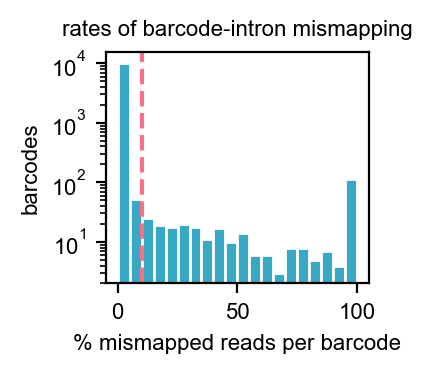

In [248]:
hist_data=dists5
t = tol
plt.figure(figsize=(1.7,1.5))
plt.hist(hist_data*100, bins=20,
         edgecolor='w', facecolor=nicecolors(3))
#plt.title(f'mean 5\' end edit distance per barcode\nfor reads with correct splice site sequences\n', fontsize=8)
plt.title('rates of barcode-intron mismapping', fontsize=8)
plt.xlabel('% mismapped reads per barcode')
plt.ylabel('barcodes')
plt.axvline(t*100, linestyle='--')
#plt.annotate(f'{(hist_data<=t).sum()*100/len(hist_data):.1f}%', xy=((t*0.8)-2,8000), fontsize=8)
#plt.annotate(f'{(hist_data>t).sum()*100/len(hist_data):.1f}%', xy=(t+2,8000), fontsize=8)
plt.yscale('log')
#plt.ylim(0,11000)
#plt.xticks(np.arange(0,18,2))
plt.show()

### what do reads from putatively mismapped bcs look like?

In [133]:
mismapped_bcs = np.array(bcs)[error5]
len(mismapped_bcs)

313

In [245]:
from collections import Counter

plus11 = []
to_print = 10
printed = 0

for bc in mismapped_bcs:
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    list_of_int_reads = [(x[1][28:], rc(x[0])[:4]) for x in RIL2_unspliced[bc]]
    readcounts = Counter(list_of_int_reads)
    top_read, top_count = readcounts.most_common(1)[0]
        
    if printed<to_print:
        print(f'\nbc: {bc}')
        print(f'    exp: {expected_5end}    {expected_3end}')
        print(f'    obs: {top_read[0]}    {top_read[1]}')
        print(f'    dists: {lev(expected_5end,top_read[0])}               {lev(expected_3end,top_read[1])}')
        print(f'    +11 5\'SS? {lev(top_read[0],exon2+bc[:6])<=2}')
        print(f'    count: {top_count}/{len(list_of_int_reads)}')
        print()
        printed+=1

    if lev(top_read[0],exon2+bc[:6])<=2:
        plus11.append(bc)
    elif len(readcounts)>1:
        top_read2, top_count2 = readcounts.most_common(2)[1]
        if lev(top_read2[0],exon2+bc[:6])<=2:
            plus11.append(bc)
        if printed<to_print:
            print(f'    exp: {expected_5end}    {expected_3end}')
            print(f'    obs: {top_read2[0]}    {top_read2[1]}')
            print(f'    dists: {lev(expected_5end,top_read2[0])}               {lev(expected_3end,top_read2[1])}')
            print(f'    +11 5\'SS? {lev(top_read2[0],exon2+bc[:6])<=2}')
            print(f'    count: {top_count2}/{len(list_of_int_reads)}')
            print()


bc: CCTCATAATCTTTCCTAA
    exp: GTGAGTATAAATCTTC    CGGC
    obs: GTGTCGTGAACCTCAT    TGTT
    dists: 8               3
    +11 5'SS? True
    count: 438/720


bc: CCCTTATAATCTTTCTTT
    exp: TGCGTACTATATTGCC    AAGG
    obs: TGCGTACTATATTGCC    CAAG
    dists: 0               2
    +11 5'SS? False
    count: 194/258

    exp: TGCGTACTATATTGCC    AAGG
    obs: TGTCGTGAACCCTTAT    TTGT
    dists: 10               3
    +11 5'SS? True
    count: 60/258


bc: CAATCTATCTTCCCTTTT
    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACCG
    dists: 9               3
    +11 5'SS? False
    count: 42/44

    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACTG
    dists: 9               3
    +11 5'SS? False
    count: 1/44


bc: ATCATACTCCAACTCACA
    exp: CCTGCCAGCCAGATAT    GAGT
    obs: ACAGCGCTTAGCATCT    GTGG
    dists: 8               2
    +11 5'SS? False
    count: 14/14


bc: ACTAACTCCATATACTAA
    exp: GTAAGTTACACGCTAT    TTCC
    obs: GTAAGTTACACGCTAT    TTCC

In [246]:
# how many of the "mismapped" bcs are actually cryptic splicing with +11 G?
len(plus11)

127

In [136]:
truly_mismapped_bcs = [x for x in mismapped_bcs if x not in plus11]

In [232]:
((hist_data>t).sum()/len(hist_data))

0.029789664033501476

In [234]:
(hist_data<=t).sum()

10194

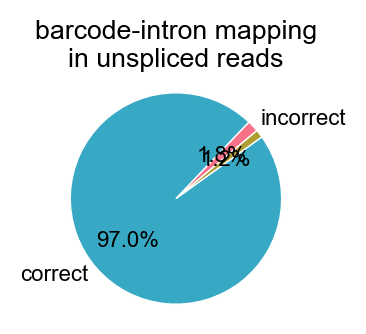

In [249]:
# modify with bcs identified as cryptically spliced to +11 G in manual examination:

labels = ['incorrect','correct','']
sizes = [((hist_data>t).sum()-len(plus11))*100/len(hist_data),
        ((hist_data<=t).sum())*100/len(hist_data),
        len(plus11)*100/len(hist_data)]
colors = [nicecolors(i) for i in [0,3,1]]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(1.5,1.5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=40, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('barcode-intron mapping\nin unspliced reads')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

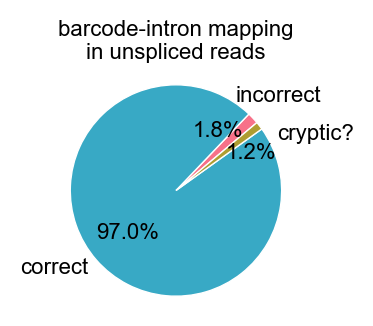

In [286]:
import matplotlib.pyplot as plt
import numpy as np

# Custom function to format the labels
def format_pct(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"

labels = ['incorrect','correct','cryptic?']
sizes = [((hist_data>t).sum()-len(plus11))*100/len(hist_data),
        ((hist_data<=t).sum())*100/len(hist_data),
        len(plus11)*100/len(hist_data)]
colors = [nicecolors(i) for i in [0,3,1]]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(1.5, 1.5))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=lambda pct: format_pct(pct, sizes), 
                                   startangle=40, wedgeprops={'edgecolor': 'w', 'linewidth': 0.5})

texts[0].set_position((0.7 * texts[0].get_position()[0], 1.2 * texts[0].get_position()[1]))
texts[2].set_position((1.1 * texts[2].get_position()[0], 0.8 * texts[2].get_position()[1]))
autotexts[0].set_position((0.9 * autotexts[0].get_position()[0], 1.4 * autotexts[0].get_position()[1]))
autotexts[2].set_position((1.5 * autotexts[2].get_position()[0], 1.0 * autotexts[2].get_position()[1]))

plt.title('barcode-intron mapping\nin unspliced reads', fontsize=8)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


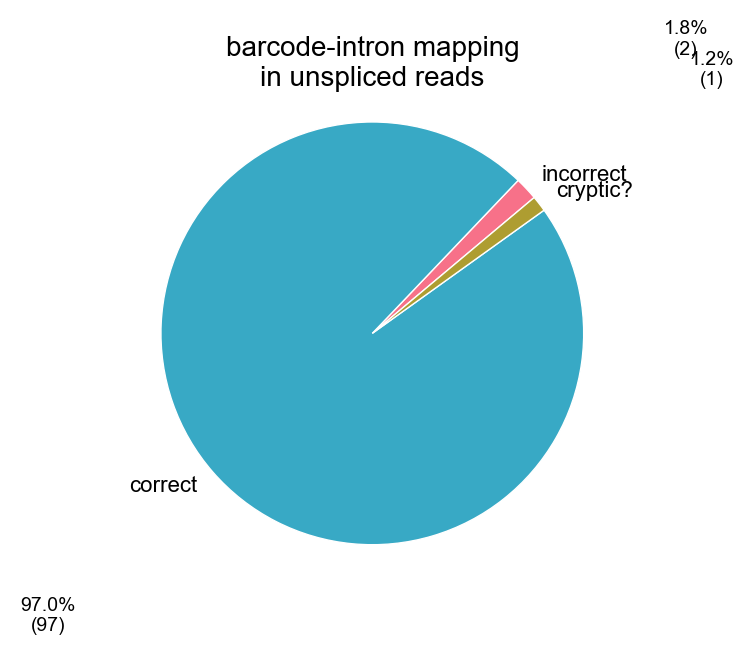

In [269]:
import matplotlib.pyplot as plt
import numpy as np

# Custom function to format the labels
def format_pct(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

labels = ['incorrect', 'correct', 'cryptic?']
sizes = [((hist_data > t).sum() - len(plus11)) * 100 / len(hist_data),
         ((hist_data <= t).sum()) * 100 / len(hist_data),
         len(plus11) * 100 / len(hist_data)]
explode = (0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(3, 3))  # Slightly larger figure for better spacing
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=lambda pct: format_pct(pct, sizes),
                                   startangle=40, wedgeprops={'edgecolor': 'w', 'linewidth': 0.5},
                                   pctdistance=1.85)  # Move the percentage labels outside

# Adjust the properties of the percentage labels
for autotext in autotexts:
    autotext.set_fontsize(7)
    # Positioning the percentage labels slightly outside the wedges
    autotext.set_position((1.1 * autotext.get_position()[0], 1.1 * autotext.get_position()[1]))

# Adjust the properties of the text labels
for text in texts:
    text.set_fontsize(8)

plt.title('barcode-intron mapping\nin unspliced reads', fontsize=10)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [138]:
to_print = 6
printed = 0

for bc in truly_mismapped_bcs:
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    list_of_int_reads = [(x[1][28:], rc(x[0])[:4]) for x in RIL2_unspliced[bc]]
    readcounts = Counter(list_of_int_reads)
    top_read, top_count = readcounts.most_common(1)[0]
        
    if printed<to_print:
        print(f'\nbc: {bc}')
        print(f'    exp: {expected_5end}    {expected_3end}')
        print(f'    obs: {top_read[0]}    {top_read[1]}')
        print(f'    dists: {lev(expected_5end,top_read[0])}               {lev(expected_3end,top_read[1])}')
        print(f'    count: {top_count}/{len(list_of_int_reads)}')
        print()
        printed+=1

    if len(readcounts)>1:
        top_read2, top_count2 = readcounts.most_common(2)[1]
        if printed<to_print:
            print(f'    exp: {expected_5end}    {expected_3end}')
            print(f'    obs: {top_read2[0]}    {top_read2[1]}')
            print(f'    dists: {lev(expected_5end,top_read2[0])}               {lev(expected_3end,top_read2[1])}')
            print(f'    count: {top_count2}/{len(list_of_int_reads)}')
            print()


bc: CAATCTATCTTCCCTTTT
    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACCG
    dists: 9               3
    count: 42/44

    exp: ATCCCTAGAGCTTGCA    GAAG
    obs: TTGGTCTGCCCTTCAA    ACTG
    dists: 9               3
    count: 1/44


bc: ATCATACTCCAACTCACA
    exp: CCTGCCAGCCAGATAT    GAGT
    obs: ACAGCGCTTAGCATCT    GTGG
    dists: 8               2
    count: 14/14


bc: CTTCTTCTCCTATTCTTT
    exp: CCACTTGGACTTGATA    CCTC
    obs: CACTTGGACTTGATAT    CCTC
    dists: 2               0
    count: 57/59

    exp: CCACTTGGACTTGATA    CCTC
    obs: CACTTGGCCTTGATAT    CGTC
    dists: 3               1
    count: 1/59


bc: TCATCTAACCCACACTTT
    exp: GGACTTAATACGTGTT    GGGT
    obs: TTGGACTTAATACGTG    GGGT
    dists: 4               0
    count: 11/11


bc: CTTCCTACTTCCTCTCCT
    exp: ATGTTGGTGAGGACGG    TCTT
    obs: TGTTGGTGAGAACGGC    TCTT
    dists: 3               0
    count: 17/17


bc: TAACTATTTTTTCACTTA
    exp: GCTCAACGTAGTGATT    GCGT
    obs: GCTCAACGTA

# heat maps of error positions in reads

In [45]:
# generate a list of tuples representing the lev distance between observed and expected seq
# for each reverse (5' end of amplicon) and forward (3' end, must take reverse complement) read pair

# lengths 16, 12, 16, 4, 40, 10
RIL2_unspliced_vectors = {b:[] for b in RIL2_unspliced}
exon1 = 'TGATCGTCGTCACCAG'
fiveSS_seq = 'GTGAGTAGCGGG'
threeSS_seq_1 = 'GCCTCAGACAGTGGTTCAAA'
threeSS_seq_2 = 'GTTTTTTTCTTCCATTTCAG'
exon2 = 'GTGTCGTGAA' 

for bc, reads in RIL2_unspliced.items():
    expected_5end = b2i[bc][12:28]
    expected_3end = b2i[bc][-44:-40]
    for read in reads:
        fread = read[0]
        rread = read[1]
        exon1_score = lev(rread[:16], exon1)
        SS_score5 = lev(rread[16:28], fiveSS_seq)
        dist5 = lev(rread[28:], expected_5end)
        dist3 = lev(rc(fread)[:4], expected_3end)
        SS_score_31 = lev(rc(fread)[4:24], threeSS_seq_1)
        SS_score_32 = lev(rc(fread)[24:44], threeSS_seq_2)
        exon2_score = lev(rc(fread)[44:54], exon2)
        RIL2_unspliced_vectors[bc].append([exon1_score,SS_score5,dist5,dist3,SS_score_31,SS_score_32,exon2_score])

        #RIL2_unspliced_vectors[bc].append({'exon 1':exon1_score,
        #                                   '5\' SS':SS_score5,
        #                                   '5\'end of intron':dist5,
        #                                   '3\'end of intron':dist3,
        #                                   '3\' SS':SS_score_3,
        #                                   'exon 2':exon2_score})

In [22]:
all_vectors = flatten([x for x in RIL2_unspliced_vectors.values()]) 
all_nonzero_vectors = np.array(all_vectors)[np.array(all_vectors).sum(1)!=0]
print(len(all_nonzero_vectors))

535373


In [23]:
lengths = [16, 12, 16, 4, 20, 20, 10]
nonzero_norm_vectors = all_nonzero_vectors/np.array(lengths)
expanded_vectors = np.array([[val for val, count in zip(x, lengths) for _ in range(count)] for x in nonzero_norm_vectors])

In [24]:
spacer_length = 8
exp_vecs_w_spacer = np.concatenate([expanded_vectors[:,:(16+12+16)],
                                   np.zeros(((expanded_vectors.shape[0]),spacer_length)),
                                   expanded_vectors[:,(16+12+16):]], axis=1)

/Users/emmakowal/miniconda3/envs/random_IME_screens_meta_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2400x2000 with 0 Axes>

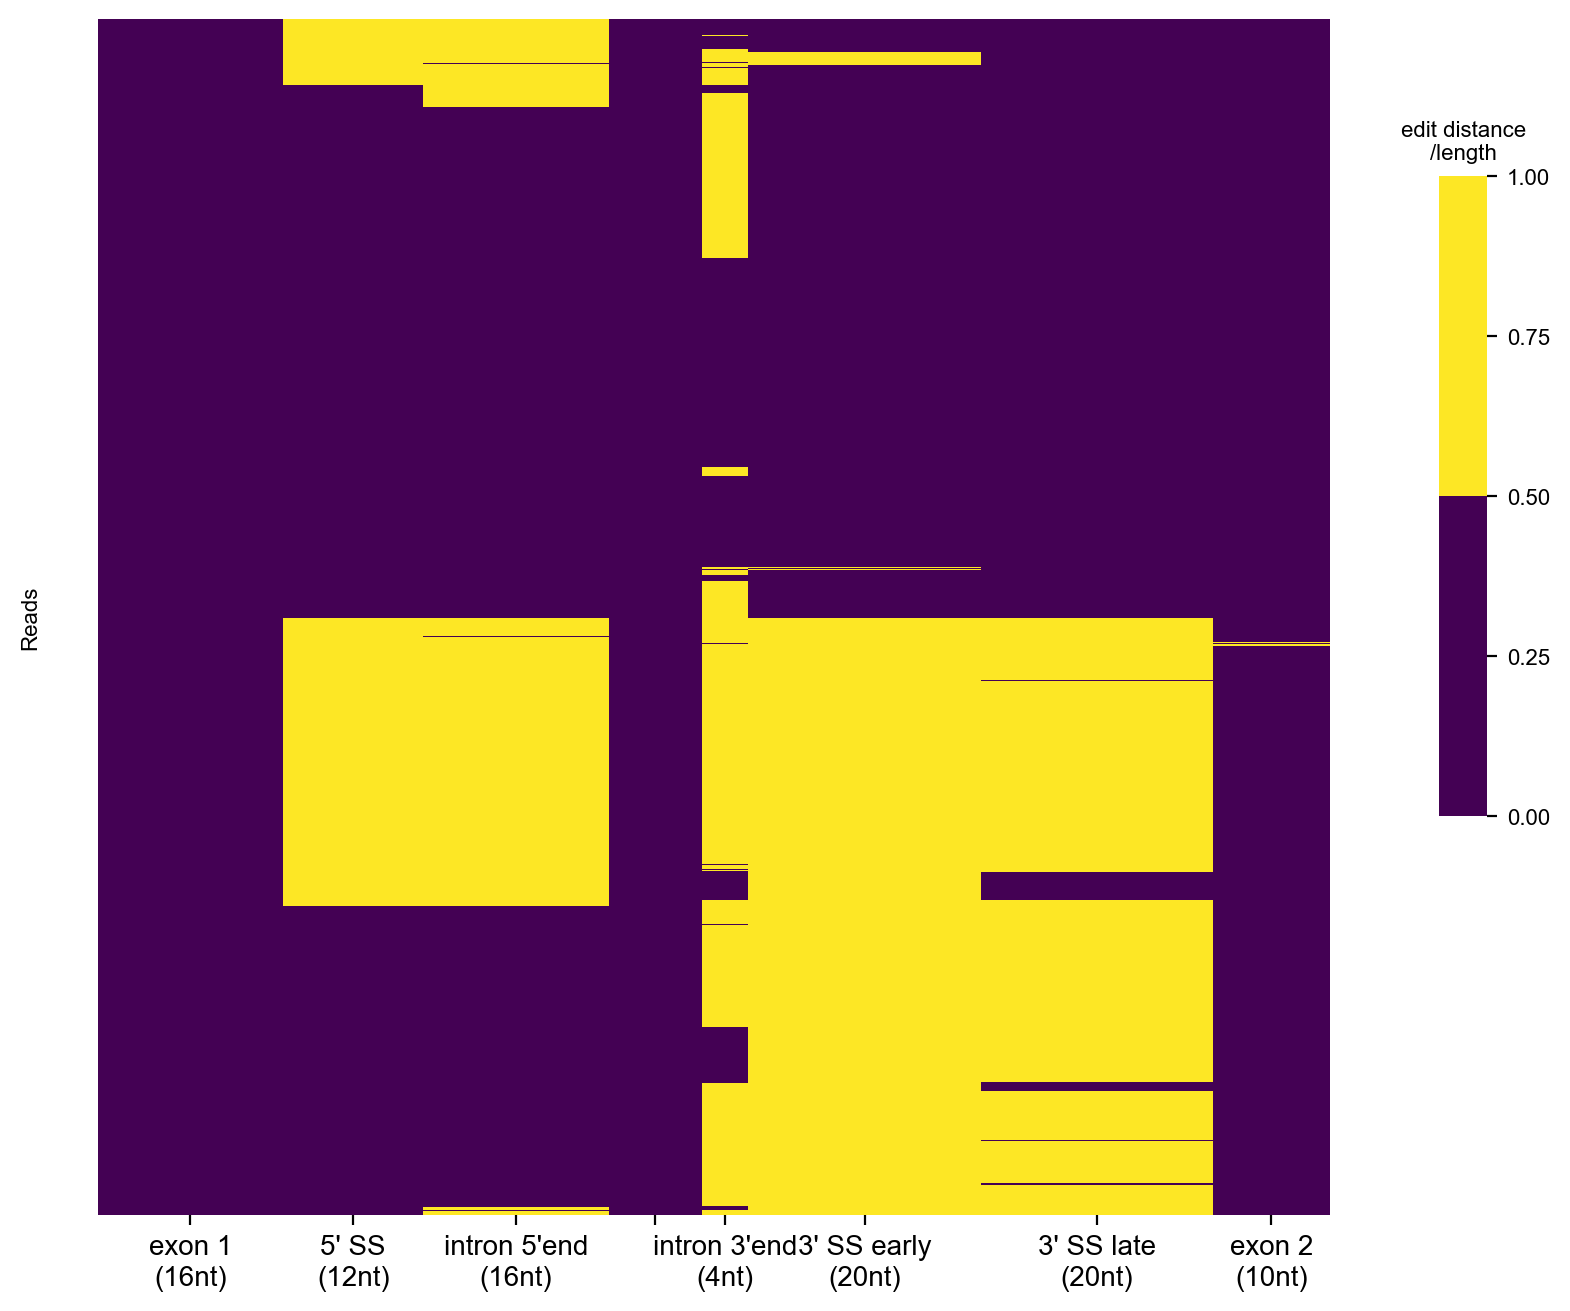

In [25]:
vecs = exp_vecs_w_spacer
row_indices = np.random.choice(vecs.shape[0], size=8000, replace=False)
vectors_to_plot = vecs[row_indices, :]

df = pd.DataFrame(vectors_to_plot)
#df.columns = RIL2_unspliced_vectors.keys()
#df.columns = [f'Position {i+1}' for i in range(6)]

#n_bins = 13
#cmap = plt.get_cmap('gnuplot2_r', n_bins)
#bounds = np.linspace(0, 26, n_bins + 1)  # create bounds for your data
#norm = colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds

n_bins = 2
cmap = plt.get_cmap('viridis', n_bins)
bounds = np.linspace(0, 1, n_bins + 1)  # create bounds for your data
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds


# Plotting the heatmap with hierarchical clustering
plt.figure(figsize=(12, 10))
cg = sns.clustermap(df, method='complete', metric='euclidean', figsize=(8,8), 
                   col_cluster=False, cmap=cmap, norm=norm,
                   cbar_pos=(1.05, 0.3, 0.03, 0.4),
                    yticklabels=False)

plt.title('Clustered Heatmap of Barcode Vectors')

lengths_w_spacer = [16, 12, 16, spacer_length, 4, 20, 20, 10]
cg.ax_heatmap.set_xticks([(l/2)+np.sum(lengths_w_spacer[:i]) for i,l in enumerate(lengths_w_spacer)])
cg.ax_heatmap.set_xticklabels(['exon 1\n(16nt)', '5\' SS\n(12nt)',
                               'intron 5\'end\n(16nt)',
                               '',
                               'intron 3\'end\n(4nt)',
                               '3\' SS early\n(20nt)', 
                               '3\' SS late\n(20nt)',
                               'exon 2\n(10nt)'], 
                              fontsize=10, rotation=0
                             )
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Reads\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('edit distance\n/length', fontsize=8)
cg.cax.set_yticks([0,0.25,0.5,0.75,1])

plt.show()

# analysis of splicing heterogeneity in unspliced reads

My primary goal for this analysis is to classify each unspliced read as one of 3 possible events: 

1. canonical unspliced (i.e. expected pre-mRNA sequence for that intron, or close enough to be seq error)
2. cryptic 5' or 3' splicing event (and examine in more detail how this may be occurring)
3. barcode-intron mapping error

What would an unspliced read with NO cryptic splicing look like?
- the 5'->3' read (actually the reverse read in the seq scheme, though I will refer to it as the 5' read to avoid confusion) should contain the constant 5'SS plus the beginning of the 5' end of the random region of the intron
- the 3'->5' read begins with the sample index and extends 54 bases past the barcode. in a true unspliced read, this will be 10 bases of spacer, 40 bases of constant 3'SS, and 4 bases of the 3' end of the intron random region.

example read pair for barcode TTTTTTTTCTTACATTTT:
```
  exon-intron boundary:                ||           ****************
               5' read: TGATCGTCGTCACCAGGTGAGTAGCGGGGTGCATTCGTACAGTT
expected 5'ss sequence:                 GTGAGTAGCGGGGTGCATTCGTACAGTT

  intron-exon boundary: ****                                       ||
               3' read: GTGTGCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAGGTGTCGTGAATTTTTT...
expected 3'ss sequence: GTGTGCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG

```
(*** indicates random sequence)

note that this is indistinguishable from splicing of an internal intron with cryptic 5'SS *and* cryptic 3'SS if these SS are more than 22 bases and 44 bases into the random region, respectively. However, I believe this is unlikely.

As the first step, I will calculate for each read the Levenshtein distance between observed and expected sequences for all unspliced reads:

In [46]:
# generate a list of tuples representing the lev distance between observed and expected seq
# for each reverse (5' end of amplicon) and forward (3' end, must take reverse complement) read pair

RIL2_unspliced_dists = {b:[] for b in RIL2_unspliced}
fiveSS_seq = 'GTGAGTAGCGGG'
threeSS_seq = 'GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG'

for bc, reads in RIL2_unspliced.items():
    expected_5seq = fiveSS_seq+b2i[bc][12:28]
    for read in reads:
        fread = read[0]
        rread = read[1]
        observed_5seq = rread[16:]
        observed_3seq = rc(fread)[4:44]
        dist5 = lev(expected_5seq, observed_5seq)
        dist3 = lev(threeSS_seq, observed_3seq)
        RIL2_unspliced_dists[bc].append((dist5,dist3))

In [47]:
# convert dict to lists for plotting

all_reads_dists = flatten([dlist for bc, dlist in RIL2_unspliced_dists.items()])
all_bcs_dlists = [np.array(dlist) for bc, dlist in RIL2_unspliced_dists.items()]
all_bcs_mean_dists = [(np.mean([d[0] for d in dlist]),np.mean([d[1] for d in dlist])) for dlist in all_bcs_dlists]

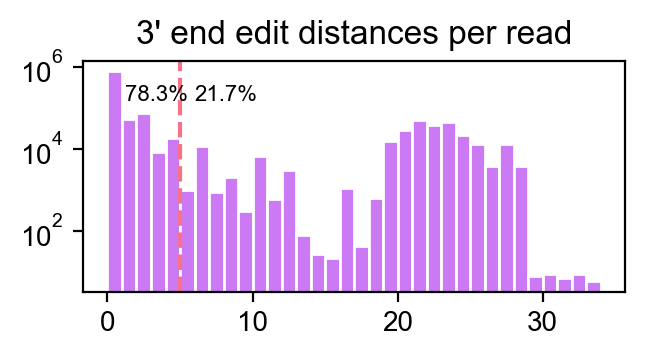

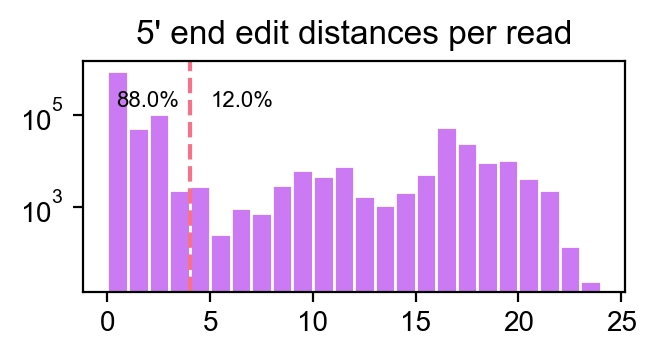

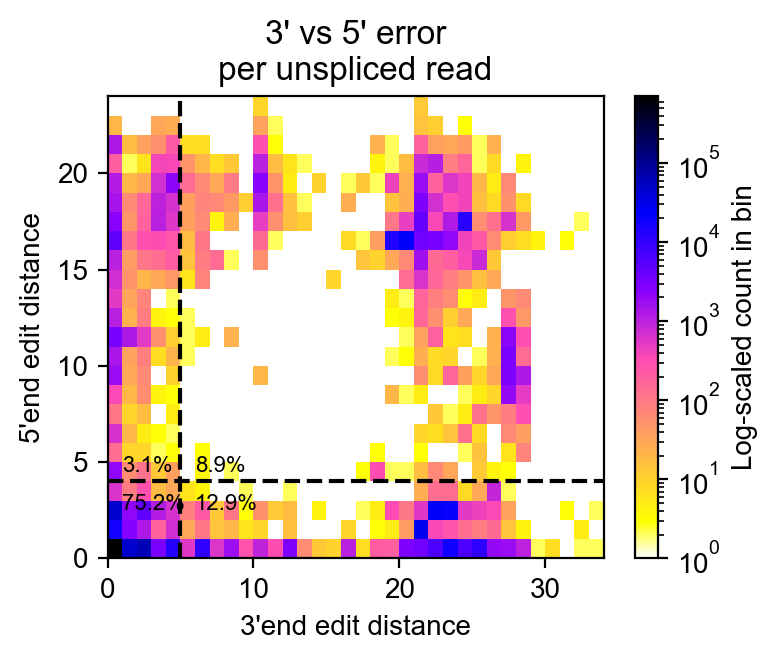

In [48]:
# set max error tolerances for calling read a match
# then compute fraction of matching reads per barcode

tol5 = round(perc_99*len(observed_5seq))
tol3 = round(perc_99*len(observed_3seq))

data = np.array(all_reads_dists)
dists5,dists3 = data[:, 0], data[:, 1]

for e,t,hist_data in [(3,tol3,dists3), (5,tol5,dists5)]:
    plt.figure(figsize=(3.5,1.5))
    plt.hist(hist_data, bins=np.arange(max(hist_data)), edgecolor='w', facecolor=nicecolors(4))
    plt.title(f'{e}\' end edit distances per read')
    #plt.ylim(0, 60000)
    plt.axvline(t+1, linestyle='--')
    plt.annotate(f'{(hist_data<=t).sum()*100/len(hist_data):.1f}%', xy=((t*0.8)-2,150000), fontsize=8)
    plt.annotate(f'{(hist_data>t).sum()*100/len(hist_data):.1f}%', xy=(t+2,150000), fontsize=8)
    plt.yscale('log')
    plt.show()

# plot 5' vs 3' error for all unspliced reads

bins = (np.arange(max(dists3)),
        np.arange(max(dists5)))
counts, xedges, yedges = np.histogram2d(dists3,dists5, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(4,3))
hist = plt.hist2d(dists3,dists5, bins=bins, cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max()))

plt.colorbar(hist[3], label='Log-scaled count in bin')
plt.xlabel('3\'end edit distance')
plt.ylabel('5\'end edit distance')
plt.title('3\' vs 5\' error\nper unspliced read')

plt.axvline(tol3+1, c='k',linestyle='--')
plt.axhline(tol5+1, c='k',linestyle='--')

# Boolean masks for conditions
error3 = dists3 > tol3
ok3 = dists3 <= tol3
error5 = dists5 > tol5
ok5 = dists5 <= tol5

# Calculate the counts for each quadrant
q1 = (error3 & error5).sum()
q2 = (ok3 & error5).sum()
q3 = (ok3 & ok5).sum()
q4 = (error3 & ok5).sum()

plt.annotate(f'{q1*100/len(data):.1f}%', xy=(tol3+2,tol5+1.5), fontsize=8)
plt.annotate(f'{q2*100/len(data):.1f}%', xy=(tol3-3,tol5+1.5), fontsize=8)
plt.annotate(f'{q3*100/len(data):.1f}%', xy=(tol3-3,tol5-0.5), fontsize=8)
plt.annotate(f'{q4*100/len(data):.1f}%', xy=(tol3+2,tol5-0.5), fontsize=8)

plt.show()

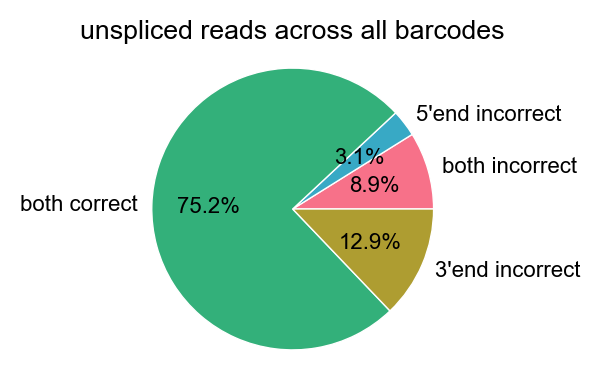

In [49]:
labels = ['both incorrect','5\'end incorrect','both correct','3\'end incorrect']
sizes = [q1,q2,q3,q4]
colors = [nicecolors(i) for i in [0,3,2,1]]
explode = (0, 0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=0, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('unspliced reads across all barcodes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

So about 76% of unspliced reads fit the description of a read that is simply unspliced, but the barcode maps to the correct intron sequence and both ends of the read contain the expected splice sites. 

How are these reads distributed among barcodes?

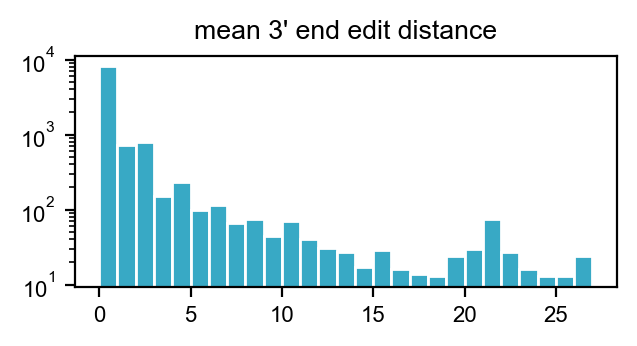

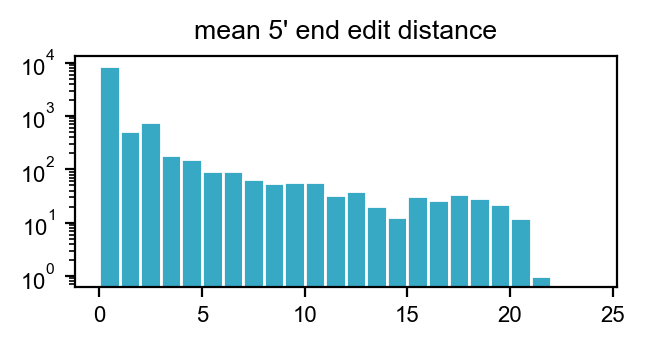

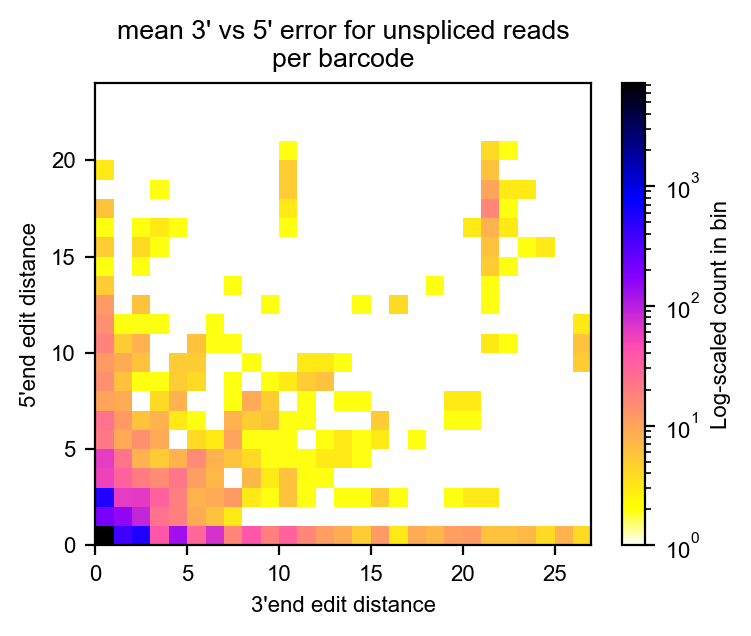

In [144]:
ydata,xdata = zip(*all_bcs_mean_dists)

for e,data in [(3,xdata), (5,ydata)]:
    plt.figure(figsize=(3.5,1.5))
    plt.hist(data, bins=np.arange(max(data)), edgecolor='w', facecolor=nicecolors(3))
    plt.title(f'mean {e}\' end edit distance')
    #plt.ylim(0,500)
    plt.yscale('log')
    plt.show()

bins = (np.arange(max(xdata)),
        np.arange(max(ydata)))
counts, xedges, yedges = np.histogram2d(xdata,ydata, bins=bins)
counts[counts == 0] = 1

plt.figure(figsize=(4,3))
hist = plt.hist2d(xdata,ydata, bins=bins, cmap='gnuplot2_r', 
                  norm=mpl.colors.LogNorm(vmin=counts.min(), vmax=counts.max()))

plt.colorbar(hist[3], label='Log-scaled count in bin')

plt.xlabel('3\'end edit distance')
plt.ylabel('5\'end edit distance')
plt.title('mean 3\' vs 5\' error for unspliced reads\nper barcode')
plt.show()

In [52]:
# plot fraction of unspliced reads which look correct per barcode
bc_ok_fractions = {b:-1 for b in RIL2_unspliced}

for bc, dlist in RIL2_unspliced_dists.items():
    if len(dlist)>1:
        dlist = np.array(dlist)
        ok5 = dlist[:,0] <= tol5
        ok3 = dlist[:,1] <= tol3
        ok = (ok3&ok5).sum()
        ok_fraction = ok/len(dlist)
        bc_ok_fractions[bc] = ok_fraction
    else:
        del bc_ok_fractions[bc]

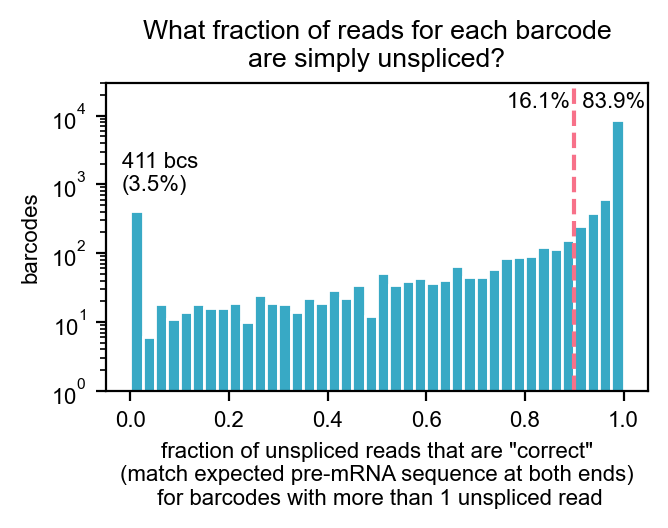

In [53]:
hist_data = bc_ok_fractions.values()

plt.figure(figsize=(3.5,2))
plt.hist(hist_data, bins=40,  
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel('fraction of unspliced reads that are "correct"\n(match expected pre-mRNA sequence at both ends)\n for barcodes with more than 1 unspliced read', fontsize=8)
plt.ylabel('barcodes')
plt.title('What fraction of reads for each barcode\nare simply unspliced?')

frac_bcs_ok = len([x for x in hist_data if x>=0.9])/len(hist_data)
plt.axvline(0.9,linestyle='--') 
plt.annotate(f'{(1-frac_bcs_ok)*100:.1f}%  {(frac_bcs_ok)*100:.1f}%',
             xy=(0.74,0.92), xycoords='axes fraction', fontsize=8)
num_always_wrong = len([x for x in hist_data if x<0.02])
plt.annotate(f'{num_always_wrong} bcs\n({num_always_wrong*100/len(hist_data):.1f}%)',
             xy=(0.03,0.65), xycoords='axes fraction', fontsize=8)
plt.yscale('log')
plt.ylim(1,30000)
plt.show()

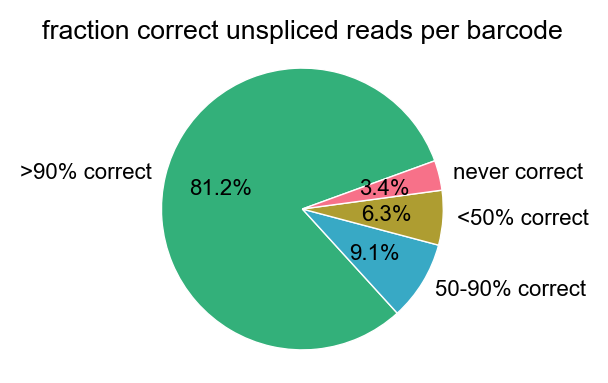

In [54]:
hist_data = bc_ok_fractions.values()

labels = ['>90% correct','50-90% correct','<50% correct','never correct']
sizes = [len([x for x in hist_data if x>=0.9]),
        len([x for x in hist_data if (x>0.5)&(x<0.9)]),
        len([x for x in hist_data if x<0.5]),
        len([x for x in hist_data if x<0.02])]
colors = [nicecolors(i) for i in [2,3,1,0]]
explode = (0, 0, 0, 0)
mpl.rcParams['font.size'] = 8

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', #shadow=True, 
        startangle=20, wedgeprops={'edgecolor': 'w','linewidth':0.5})
plt.title('fraction correct unspliced reads per barcode')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

79% of barcodes have the predicted pre-mRNA sequence in >=90% of their reads, while about 20% show some appreciable level of cryptic splicing or other unexpected sequence; 3% of these (351 barcodes) have some unexpected sequence in ALL of their unspliced reads

# What would a cryptically spliced intron with an internal 5'SS look like?

Next I will try to identify instances of cryptic splicing in the unspliced reads that do not look like the predicted mRNA sequence.

- since the 3' read goes 44nt into the 3'end of the intron, if there is a cryptic 5'SS that uses the canonical 3'SS, we will see 44nt of the new exon upstream of this cryptic 5'SS spliced to the canonical exon 2, and can use this to identify the location of the cryptic splice site.
 
the logic we can use to find these cryptic splice sites could be as follows:
- for any read with unexpected sequence at the 3' end, take terminal 20 bases of intron from read and scan across the predicted intron from barcode, compute lev distances with each window
- if you find a single position with the minimum score in all reads, store those 20 bases plus the next 20 in the intron
- what minimum score is low enough? two random sequences will on average match at 1/4 positions, which would give lev 16 in a 20nt window, but these are not random sequences (i mean, they are, but...) because they will be biased for nucleotides that give a good upstream 5'SS context. also, more importantly, we are testing every window in the intron and taking the minimum, so we are sampling from that random x random distribution ~150 times and by chance will encounter some better matches. so we should probably be conservative about this and say mean score at best position across all reads has to be <4

In [55]:
# get dict of all unexpected 3' end seqs

alt_3_seqs = {bc:[] for bc in RIL2_unspliced}

for bc in RIL2_unspliced.keys():
    dlist = RIL2_unspliced_dists[bc]
    # save any 3'end seqs (the 44 nucleotides in the intron) that do not match expected seq
    alt_seqs = [rc(s[0])[:44] for i,s in enumerate(RIL2_unspliced[bc]) if dlist[i][1] > tol3]
    alt_3_seqs[bc].append(alt_seqs)
    
for b in RIL2_unspliced:
    alt_3_seqs[b] = flatten(alt_3_seqs[b])
    if len(alt_3_seqs[b])==0:
        del alt_3_seqs[b]   

starting with 260988 reads from 3798 barcodes
2256 barcodes have at least 2 unspliced reads with unexpected intron 3' end seq
checking for potential alternative 5'SSs...


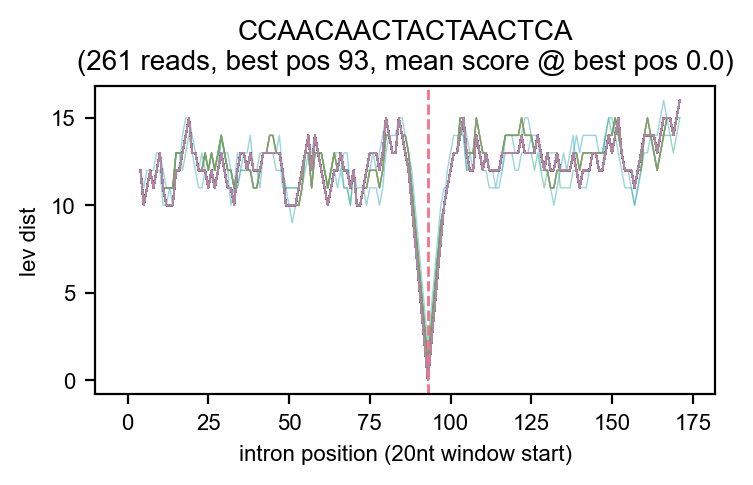

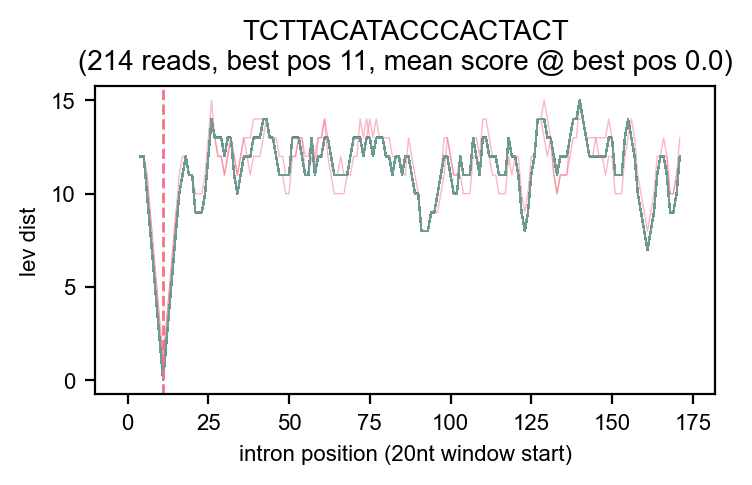

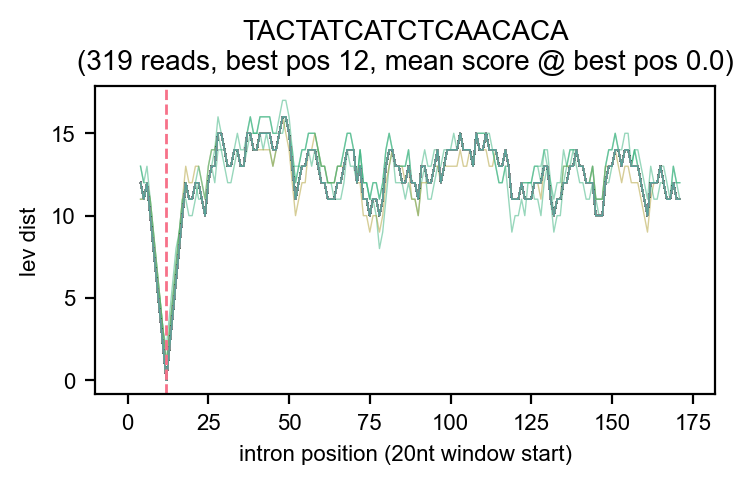

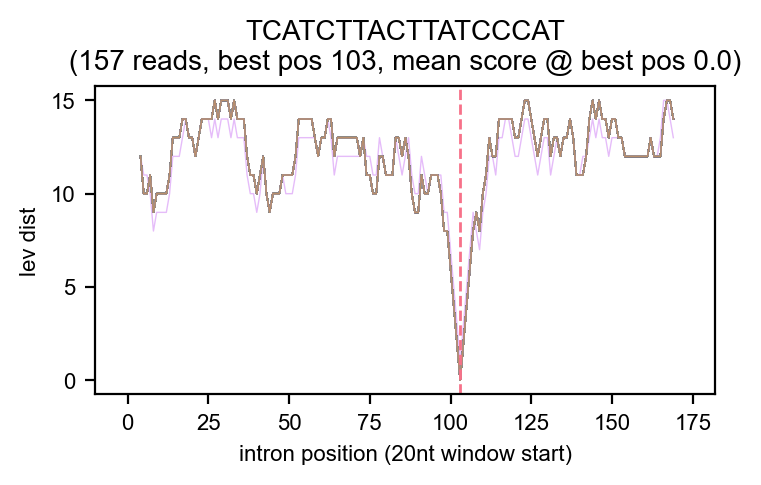

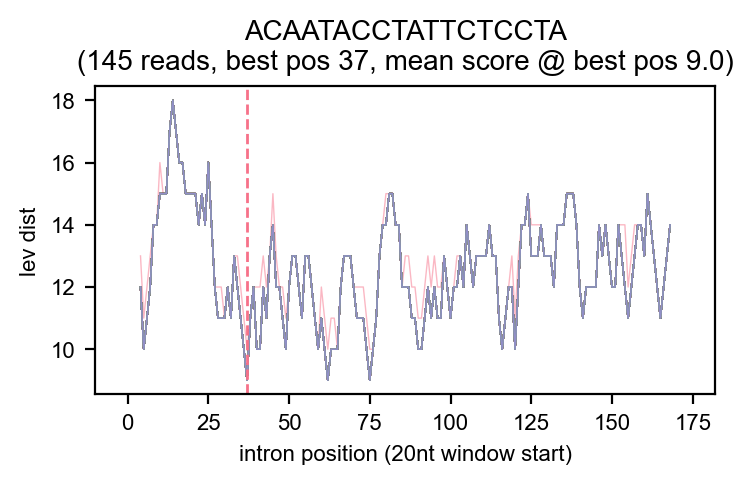

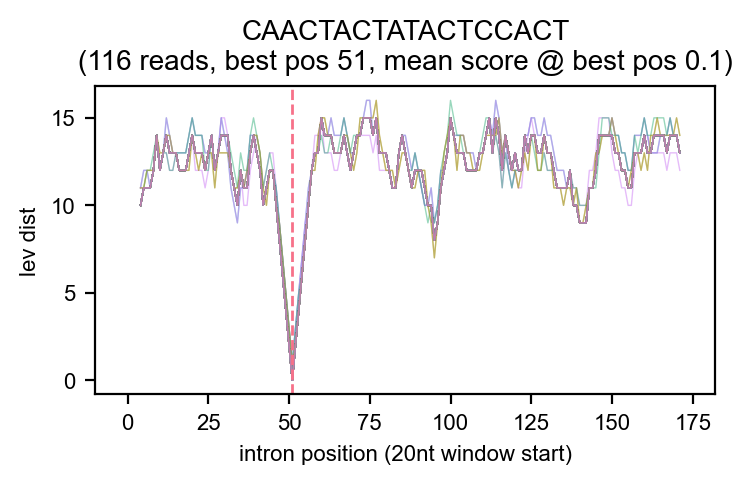

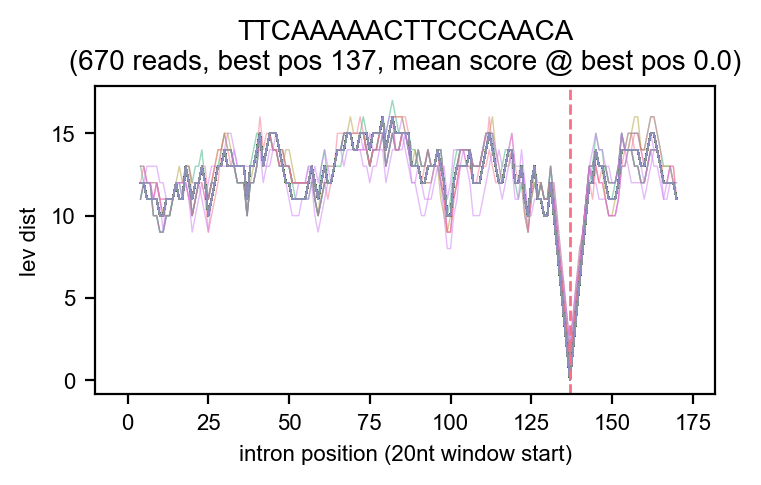

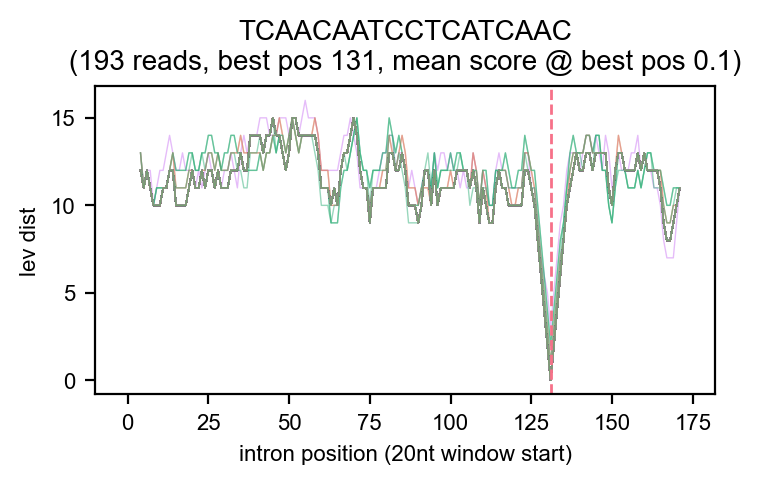

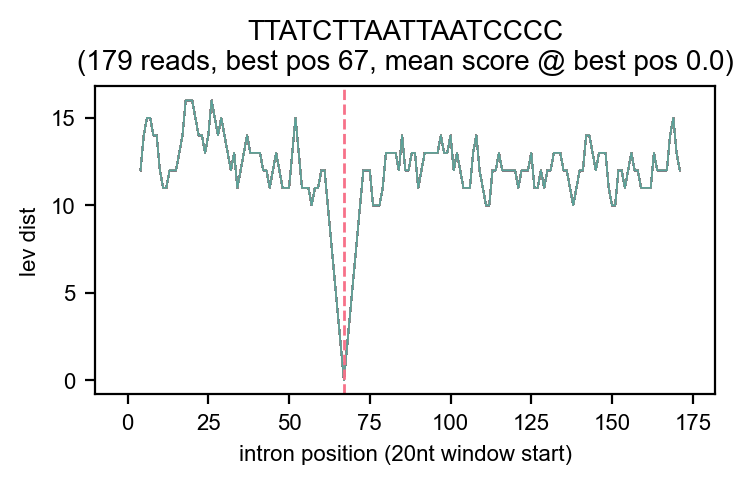

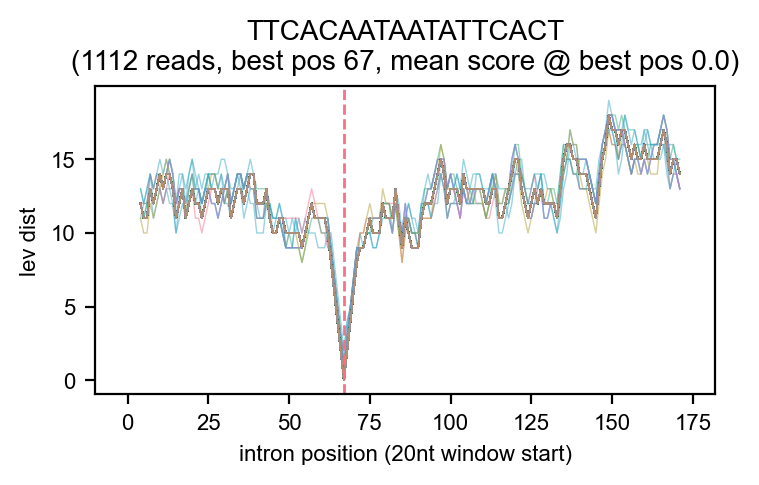

1251 of these barcodes have a single position in the intron that seems to be used as a 5'SS


In [56]:
# take the last n bases of intron from read and scan across the predicted intron to see lev distances with any given window
# if there is one position with min lev in all reads,
# store those n bases plus the next 10 in the intron

# length of read to use to scan along intron for homology
window_size = 20
exon1 = 'TGATCGTCGTCACCAG'    #add 16nt upstream exon seq to allow for possibility of SS in this region
exon2 = 'GTGTCGTGAA'    # same logic at 3' end
shift = window_size-len(exon1)

print(f'starting with {len(flatten([x for x in alt_3_seqs.values()]))} reads from {len(alt_3_seqs)} barcodes')
bcs_of_interest = [b for b,rlist in alt_3_seqs.items() if len(rlist)>=2]
print(f'{len(bcs_of_interest)} barcodes have at least 2 unspliced reads with unexpected intron 3\' end seq')

alt_3_seqs_and_scores = {b:None for b in bcs_of_interest}
print('checking for potential alternative 5\'SSs...')
plotted=0

# iterate through barcodes and assoc. reads that have unexpected 3'SS seqs
for b in bcs_of_interest:
    rlist = alt_3_seqs[b]
    intseq = exon1+b2i[b].upper()[:-40]
    positions = np.arange(0, len(intseq)-window_size)
    
    # set up containers to collect info for each barcode
    position_scores = []
    best_positions = []
    best_scores = []

    # take last n bases of intron from each seq read
    for r in rlist:
        pos_dists = []
        intread = r[(44-window_size):44]

        # scan this along expected intron and see how it matches up
        for pos in positions:
            pos_dists.append((lev(intread, intseq[pos:pos+window_size])))

        # plot these dists for each read, store list of dists & minimum dist
        if len(pos_dists)!=0:
            position_scores.append(pos_dists)
            best_positions.append(pos_dists.index(min(pos_dists)))
            best_scores.append(min(pos_dists))

    # if there is one position that all reads point to as the best match, save it
    if len(set(best_positions))==1:
        best_bet = best_positions[0]
        best_bet_mean_score = round(np.mean(best_scores), 2)

    # extract 5'SS seq from intron
        potential_alt_5SS = intseq[best_bet+window_size-3:best_bet+window_size+6]
        alt_3_seqs_and_scores[b] = (potential_alt_5SS, best_bet, best_bet_mean_score)

        # plot scores along intron for a few example reads:
        
        if plotted<10:
            #if (best_bet_mean_score<7.5)&(best_bet_mean_score>2.5):
            if len(rlist)>100:
                plt.figure(figsize=(4,2)) 
                for s in position_scores:
                    plt.plot(np.array(positions)+shift, s, linewidth=0.5, alpha=0.5)
                plt.axvline(best_bet+shift, linewidth=1, linestyle='--')
                plt.title(f'{b}\n({len(rlist)} reads, best pos {best_bet+shift}, mean score @ best pos {best_bet_mean_score:.1f})',
                         fontsize=10)
                plt.ylabel('lev dist')
                plt.xlabel(f'intron position ({window_size}nt window start)')
                plt.xlim(-10,182)
                plt.show()
                plotted+=1
    #
    elif len(set(best_positions))!=1:
        del alt_3_seqs_and_scores[b]

print(f'{len(alt_3_seqs_and_scores)} of these barcodes have a single position in the intron that seems to be used as a 5\'SS')

In [150]:
dicthead(alt_3_seqs_and_scores)

[('TATTCCCCACCCTCTCAC', ('ACGCGACTT', 43, 7.0)),
 ('CCTACCCTTCTCCATTCA', ('GGGAGTGTT', 142, 7.0)),
 ('CCCTTATAATCTTTCTTT', ('CGGGTGCGT', 7, 0.0)),
 ('CCATTCAACTAAATCCAC', ('TATAATGGG', 66, 9.0)),
 ('CCACCATATTAACCTACA', ('ATGGTAAGT', 43, 0.07)),
 ('ACCATCATCTCCTCTCAA', ('ACGGTGAGA', 119, 0.0)),
 ('TCTCCACAATACCTCCTA', ('TAGGTGAGA', 79, 0.0)),
 ('CAACTAACCTCCTTTCCC', ('CGGGTAAAA', 7, 0.0)),
 ('CTTACAATCCCTAACACA', ('TCGTTTACG', 45, 9.0)),
 ('CCCTAATCCCTATTAAAT', ('TGAGTAGCG', 0, 8.0))]

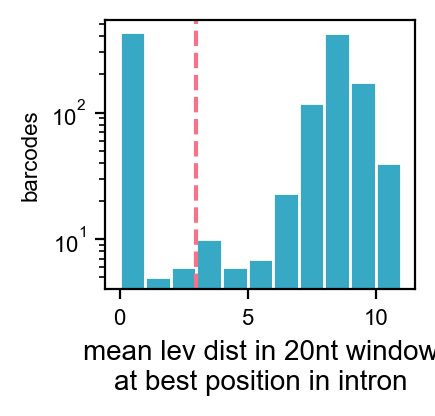

In [57]:
plt.figure(figsize=(2,1.75))
best_scores = [x[2] for x in alt_3_seqs_and_scores.values()]
plt.hist(best_scores, bins=np.arange(max(best_scores)+1), 
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel(f'mean lev dist in {window_size}nt window\nat best position in intron', fontsize=10)
plt.ylabel('barcodes')
#plt.title('what is the mean edit distance for the\nbest match position of a given barcode?')
plt.yscale('log')
plt.axvline(3,linestyle='--')
plt.show()

In [58]:
potential_alt_5ss_seqs_and_scores = {b:x for b,x in alt_3_seqs_and_scores.items() if x[2]<=2}
len(potential_alt_5ss_seqs_and_scores)

442

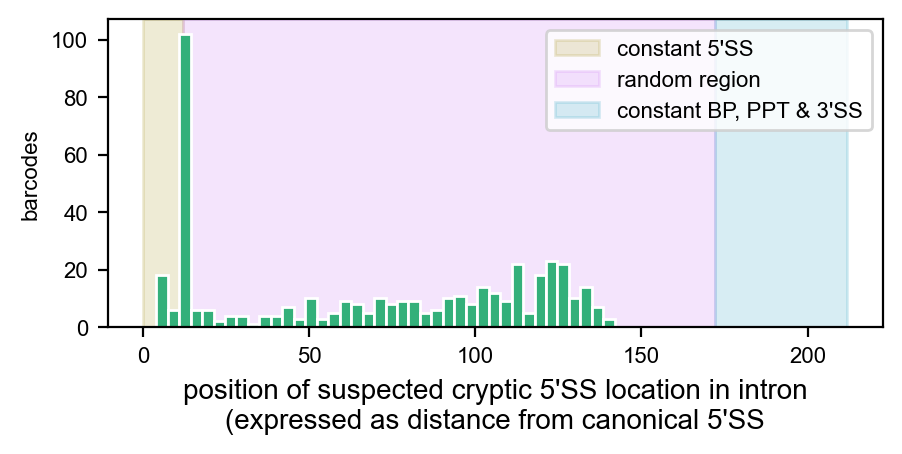

11     94
4      17
124    10
96      8
71      8
Name: count, dtype: int64

In [59]:
hist_data = [x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values()]
plt.figure(figsize=(5,2))
plt.axvspan(xmin=0,xmax=12,alpha=0.2, color=nicecolors(1), label='constant 5\'SS')
plt.axvspan(xmin=12,xmax=172,alpha=0.2, color=nicecolors(4), label='random region')
plt.axvspan(xmin=172,xmax=212,alpha=0.2, color=nicecolors(3), label='constant BP, PPT & 3\'SS')
plt.hist(hist_data, bins=40, 
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic 5\'SS location in intron\n(expressed as distance from canonical 5\'SS', fontsize=10)
plt.ylabel('barcodes')
#plt.title('distribution of \n(for introns w one best position, at which mean lev dist <=2)', fontsize=10)
#plt.ylim(0,34)

plt.legend(fontsize=8, loc=1)
plt.show()

vcs([x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values()])[:5]

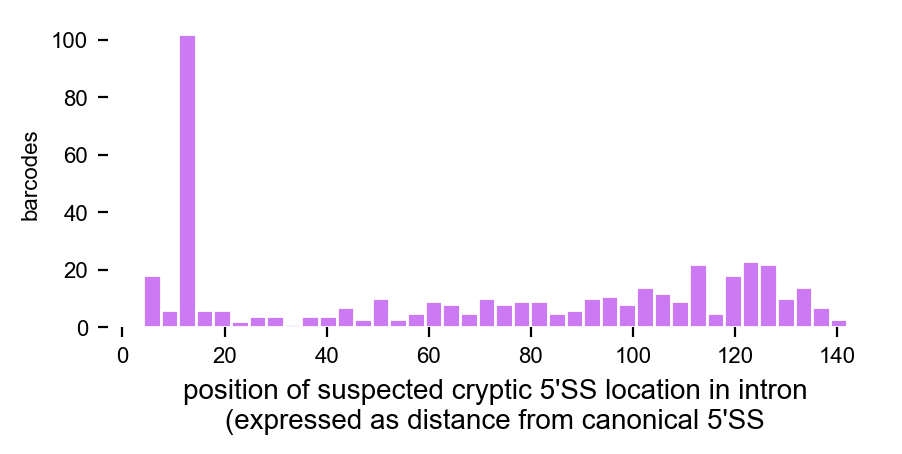

In [70]:
hist_data = [x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values()]
plt.figure(figsize=(5,2))
plt.hist(hist_data, bins=40, 
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('position of suspected cryptic 5\'SS location in intron\n(expressed as distance from canonical 5\'SS', fontsize=10)
plt.ylabel('barcodes')
plt.box(False)
plt.show()

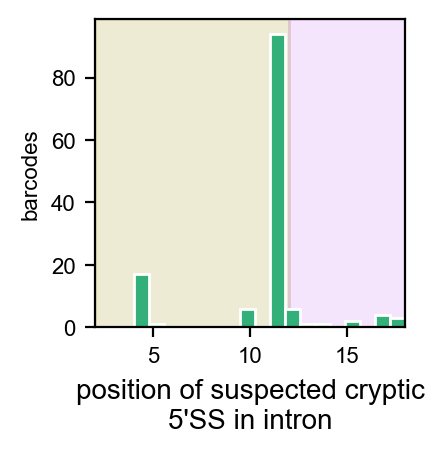

11     94
4      17
124    10
96      8
71      8
Name: count, dtype: int64

In [60]:
hist_data = [x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values() if (x[1]+shift<19)]
plt.figure(figsize=(2,2))
plt.axvspan(xmin=2,xmax=12,alpha=0.2, color=nicecolors(1), label='constant 5\'SS')
plt.axvspan(xmin=12,xmax=172,alpha=0.2, color=nicecolors(4), label='random region')
plt.hist(hist_data, bins=18,
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic\n5\'SS in intron', fontsize=10)
plt.ylabel('barcodes')
plt.xlim(2,18)
plt.show()

vcs([x[1]+shift for x in potential_alt_5ss_seqs_and_scores.values() if x[2]<=2])[:5]

In [155]:
potential_cryptic_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items()]
plus11_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[1]+shift==11)]
other_cryptic_5ss_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[1]+shift!=11)]
plus4_bcs = [b for b,x in potential_alt_5ss_seqs_and_scores.items() if (x[1]+shift==4)]
print(len(plus11_5ss_bcs))
print(len(other_cryptic_5ss_bcs))

85
320


In [156]:
plus11_5ss = [alt_3_seqs_and_scores[b][0] for b in plus11_5ss_bcs]
other_cryptic_5ss = [alt_3_seqs_and_scores[b][0] for b in other_cryptic_5ss_bcs]
plus4_ss = [alt_3_seqs_and_scores[b][0] for b in plus4_bcs]

In [159]:
# from gpt:
import logomaker
from logomaker import transform_matrix

def sequences_to_df(sequences):
    """Convert a list of sequences into a DataFrame suitable for LogoMaker."""
    
    # Ensure all sequences are the same length
    if len(set(len(seq) for seq in sequences)) != 1:
        raise ValueError("All sequences must be of the same length.")
    
    # Initialize dictionary to store counts
    counts = {'A': [0]*len(sequences[0]), 'C': [0]*len(sequences[0]), 
              'G': [0]*len(sequences[0]), 'T': [0]*len(sequences[0])}
    
    # Count each nucleotide at each position
    for seq in sequences:
        for i, nucleotide in enumerate(seq):
            if nucleotide in counts:
                counts[nucleotide][i] += 1
    
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(counts)

    info_df = transform_matrix(df, from_type='counts', to_type='information')
    
    return info_df

def set_5SS_xticks(ss_logo):
    ss_logo.ax.set_xticks(range(9))
    ss_logo.ax.set_xticklabels('%+d'%x for x in [-3, -2, -1, 1, 2, 3, 4, 5, 6])
    ss_logo.ax.set_ylim(0,2)

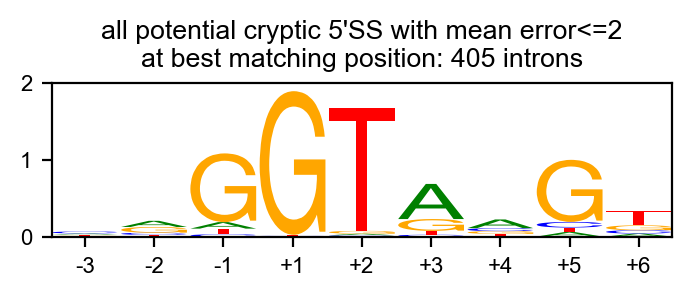

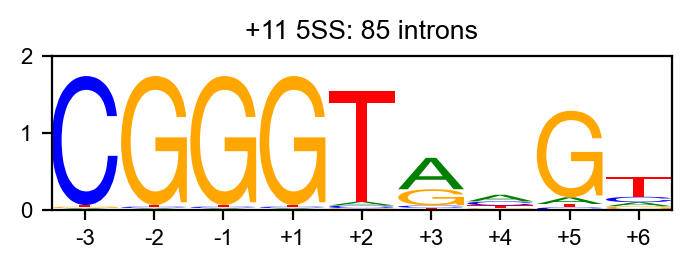

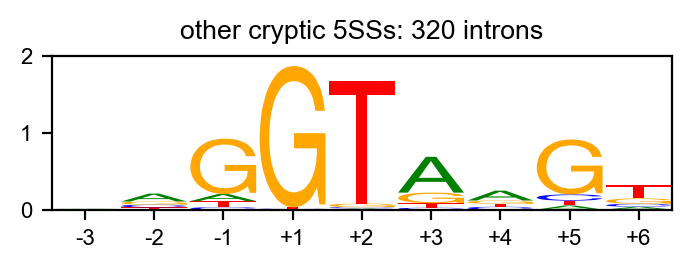

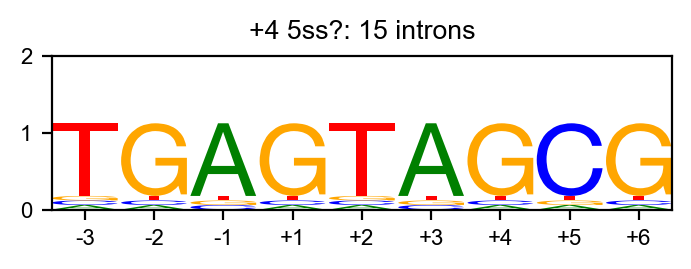

In [169]:
SS_sets = [(plus11_5ss+other_cryptic_5ss),plus11_5ss,other_cryptic_5ss, plus4_ss]
SS_set_names = ['all potential cryptic 5\'SS with mean error<=2\nat best matching position','+11 5SS','other cryptic 5SSs', '+4 5ss?']

for setname, SS_set in zip(SS_set_names,SS_sets):
    ss_logo = logomaker.Logo(sequences_to_df(SS_set), figsize=(4,1))
    set_5SS_xticks(ss_logo)
    ss_logo.ax.set_title(f'{setname}: {len(SS_set)} introns')

# Apply the same strategy to identify cryptic 3'SSs

In [63]:
# get dict of all unexpected 5' end seqs

alt_5_seqs = {bc:[] for bc in RIL2_unspliced}

for bc, dlist in RIL2_unspliced_dists.items():
    # save any 3'end seqs (the 44 nucleotides in the intron) that do not match expected seq
    alt_seqs = [s[1][16:] for i,s in enumerate(RIL2_unspliced[bc]) if dlist[i][0] > tol5]
    alt_5_seqs[bc].append(alt_seqs)
    
for b in RIL2_unspliced:
    alt_5_seqs[b] = flatten(alt_5_seqs[b])
    if len(alt_5_seqs[b])==0:
        del alt_5_seqs[b]   

starting with 143446 reads from 3875 barcodes that have any unspliced reads with unexpected intron 5' end seq
2474 of these have at least 2 reads that do not have the constant 5'SS for the library
checking for potential alternative 3'SSs...


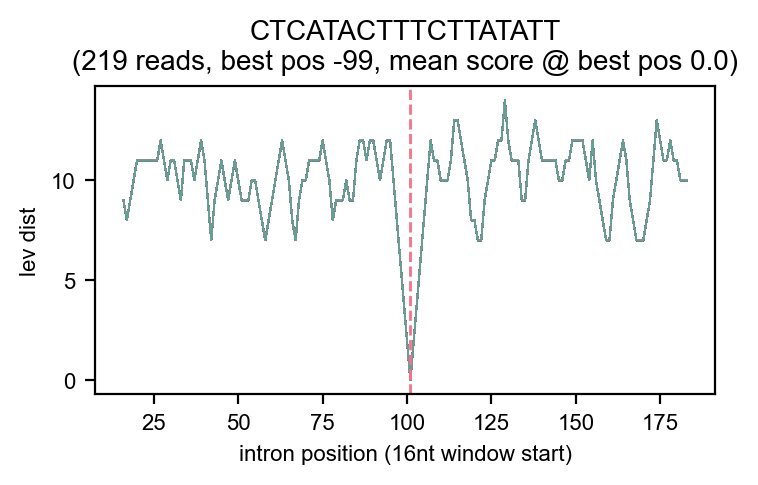

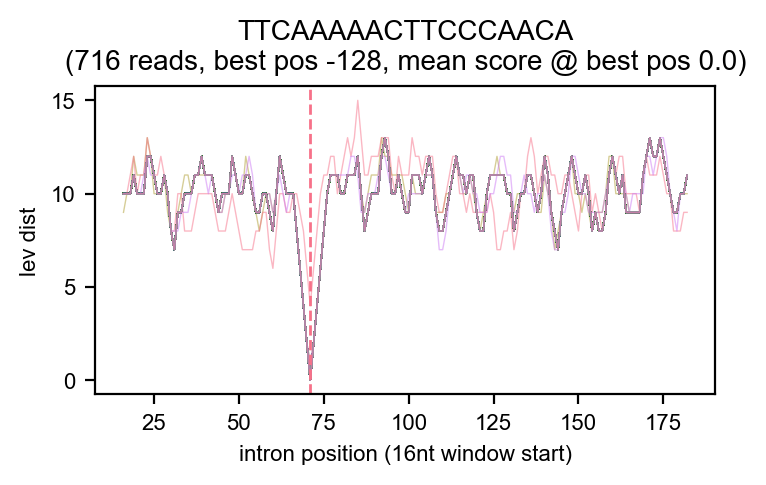

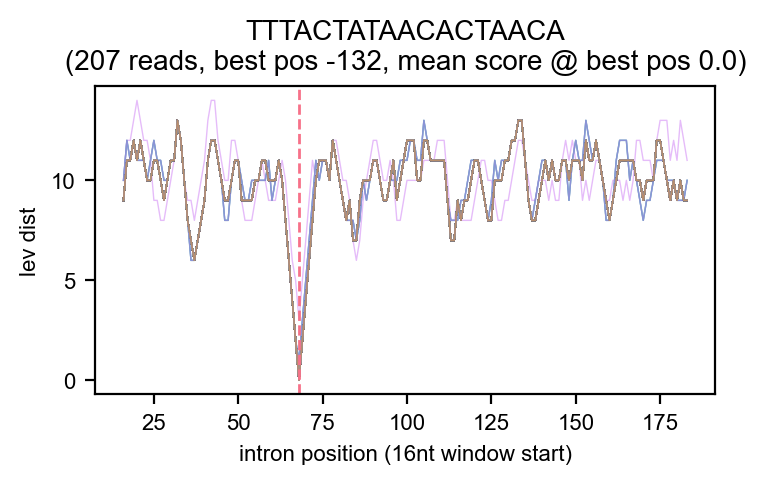

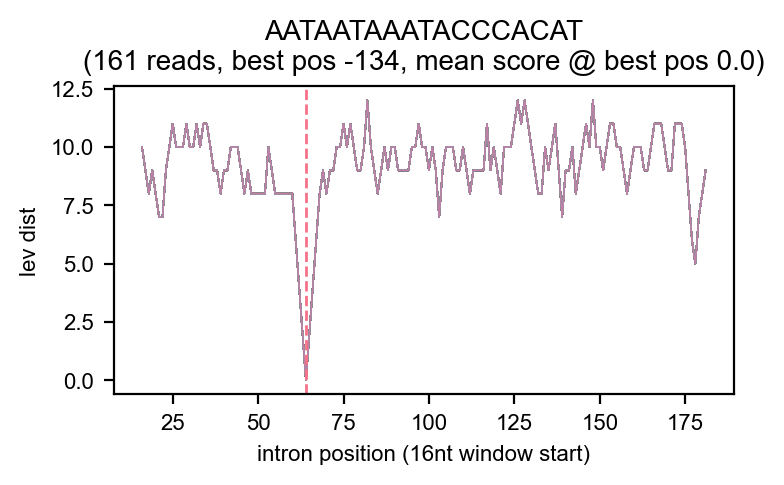

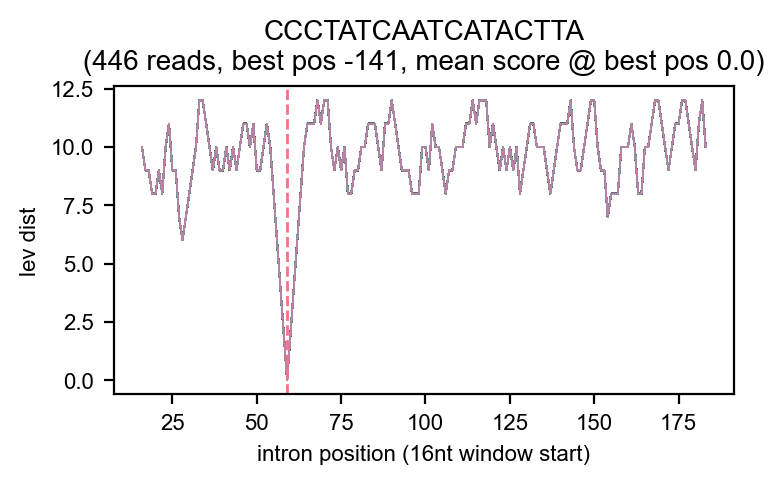

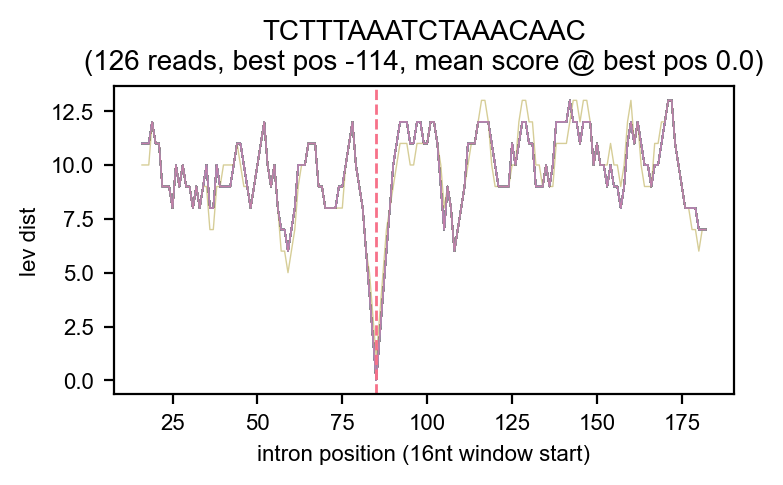

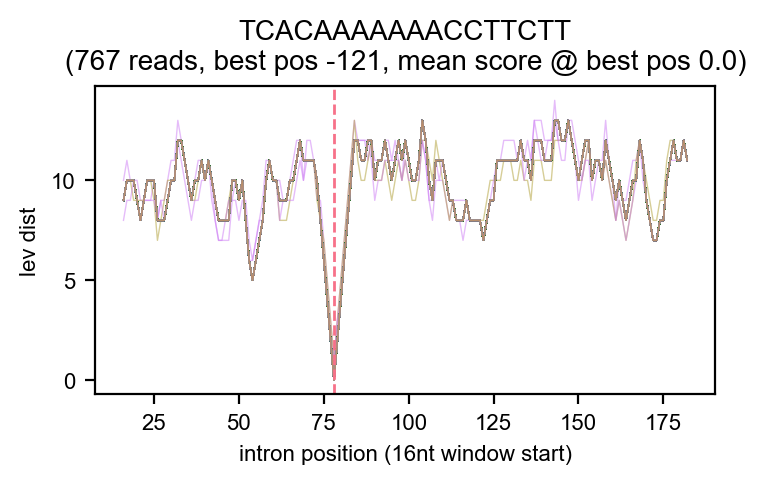

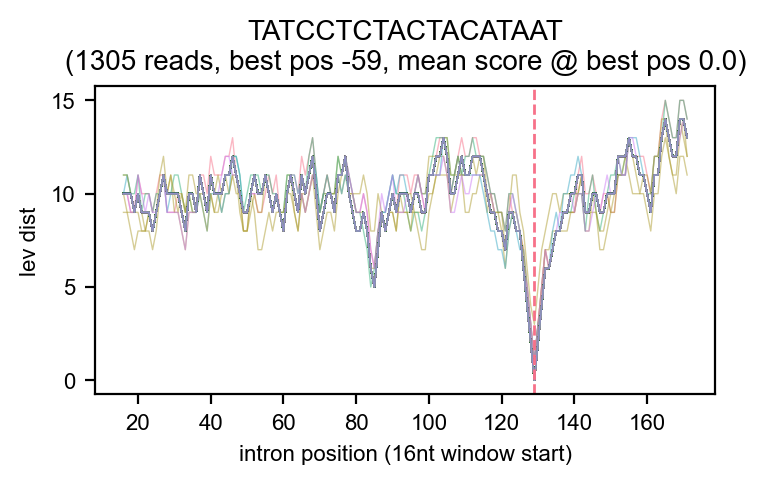

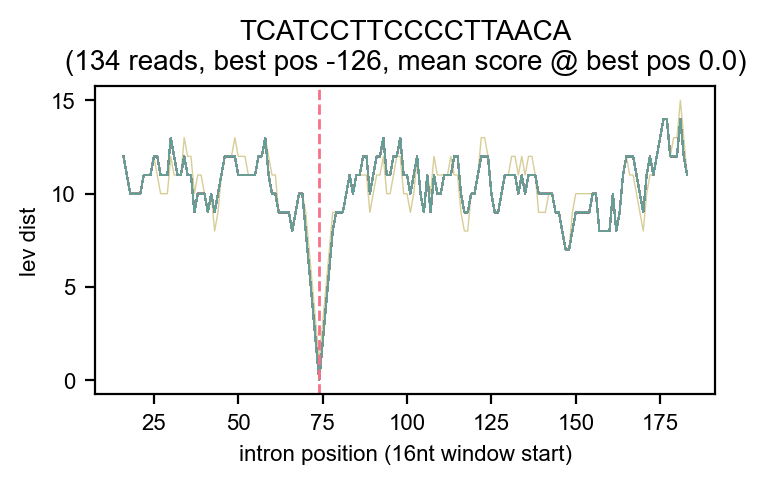

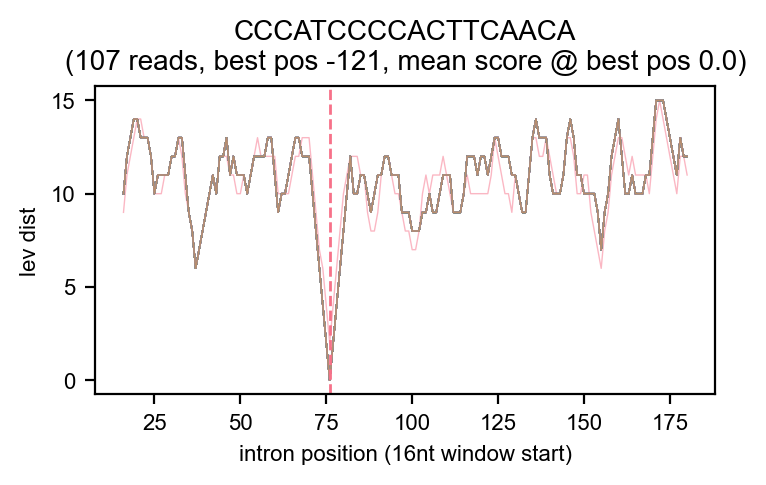

1078 of these barcodes have a single position in the intron that seems to be used as an alternative 3'SS


In [64]:
# take the n bases of intron from read and scan across the predicted intron to see lev distances with any given window

# length of read to use to scan along intron for homology
window_size = 16    # this is the maximum possible window size if the canonical 5'SS is used
exon1 = 'TGATCGTCGTCACCAG'    #add 16nt upstream exon seq to allow for possibility of SS in this region
exon2 = 'GTGTCGTGAA'    # same logic at 3' end
#shift = -1    # not sure why this works but it does, i think one-off since anchoring window at 3'end?
plotted=0

# we only care if 2 or more of reads for that barcode are unexpected
bcs_of_interest = [b for b,l in alt_5_seqs.items() if len(l)>1]
alt_5_seqs_and_scores = {b:None for b in bcs_of_interest}

print(f'starting with {len(flatten([x for x in alt_5_seqs.values()]))} reads from {len(alt_5_seqs)} barcodes that have any unspliced reads with unexpected intron 5\' end seq')
print(f'{len(bcs_of_interest)} of these have at least 2 reads that do not have the constant 5\'SS for the library')
print('checking for potential alternative 3\'SSs...')

# iterate through barcodes and assoc. reads that have unexpected 3'SS seqs
for b in bcs_of_interest:
    rlist = alt_5_seqs[b]
    intseq = b2i[b].upper()[12:]
    positions = np.arange(window_size,len(intseq)-window_size)
    intlenshift = len(intseq)-212    # pos is relative to 3' end; shift to account for variable intron length
    
    # set up containers to collect info for each barcode
    position_scores = []
    best_positions = []
    best_scores = []

    # take last n bases of intron from each seq read
    for r in rlist:
        pos_dists = []
        intread = r[:window_size]

        # scan this along expected intron and see how it matches up
        # STARTING AT 3' END
        for pos in positions:
            pos_dists.append((lev(intread, intseq[pos:pos+window_size])))

        # plot these dists for each read, store list of dists & minimum dist            
        if (len(pos_dists))>0:
            position_scores.append(pos_dists)
            best_positions.append(pos_dists.index(min(pos_dists))+window_size)
            best_scores.append(min(pos_dists))

    # if there is one position that all reads point to as the best match, save it
    if len(set(best_positions))==1:
        best_bet = best_positions[0]-len(intseq)    # store as distance from 3' end
        best_bet_mean_score = round(np.mean(best_scores), 2)

    # extract seq from intron
        potential_alt_3SS = (exon1+intseq)[best_bet-20:best_bet+3]
        alt_5_seqs_and_scores[b] = (potential_alt_3SS, best_bet, best_bet_mean_score)

        # plot scores along intron for a few example reads:
        
        if plotted<10:
            if (len(rlist)>100)&(best_bet_mean_score<=3):
                plt.figure(figsize=(4,2)) 
                for s in position_scores:
                    three_end_anchored_positions = np.array(positions)   
                    plt.plot(three_end_anchored_positions, s, linewidth=0.5, alpha=0.5)
                plt.axvline(best_bet+len(intseq), linewidth=1, linestyle='--')
                plt.title(f'{b}\n({len(rlist)} reads, best pos {best_bet}, mean score @ best pos {best_bet_mean_score:.1f})',
                         fontsize=10)
                plt.ylabel('lev dist')
                plt.xlabel(f'intron position ({window_size}nt window start)')
                #plt.xlim(2,200-window_size+10)
                plt.show()
                plotted+=1
    
    elif len(set(best_positions))!=1:
        del alt_5_seqs_and_scores[b]

print(f'{len(alt_5_seqs_and_scores)} of these barcodes have a single position in the intron that seems to be used as an alternative 3\'SS')

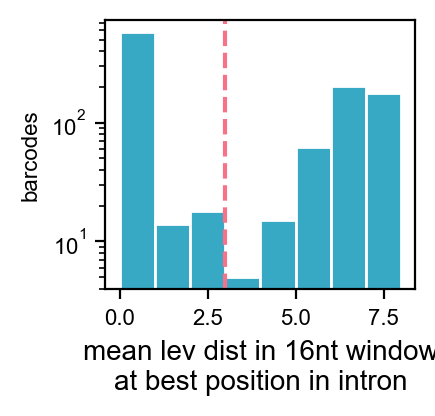

In [65]:
plt.figure(figsize=(2,1.75))
best_scores = [x[2] for x in alt_5_seqs_and_scores.values()]
plt.hist(best_scores, bins=np.arange(max(best_scores)+1), 
         edgecolor='w', facecolor=nicecolors(3))
plt.xlabel(f'mean lev dist in {window_size}nt window\nat best position in intron', fontsize=10)
plt.ylabel('barcodes')
plt.yscale('log')
plt.axvline(3,linestyle='--')
plt.show()

In [66]:
potential_alt_3ss_seqs_and_scores = {b:x for b,x in alt_5_seqs_and_scores.items() if x[2]<=2}
len(potential_alt_3ss_seqs_and_scores)

609

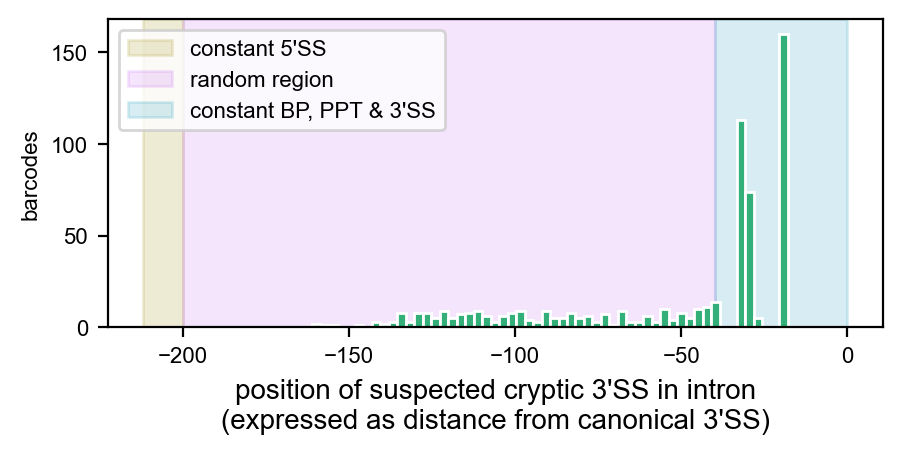

In [67]:
hist_data = [x[1] for bc,x in potential_alt_3ss_seqs_and_scores.items()]
plt.figure(figsize=(5,2))
plt.axvspan(xmin=-212,xmax=-200,alpha=0.2, color=nicecolors(1), label='constant 5\'SS')
plt.axvspan(xmin=-200,xmax=-40,alpha=0.2, color=nicecolors(4), label='random region')
plt.axvspan(xmin=-40,xmax=0,alpha=0.2, color=nicecolors(3), label='constant BP, PPT & 3\'SS')
plt.hist(hist_data, bins=56,
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic 3\'SS in intron\n(expressed as distance from canonical 3\'SS)', fontsize=10)
plt.ylabel('barcodes')
plt.legend(fontsize=8, loc=2)
plt.show()

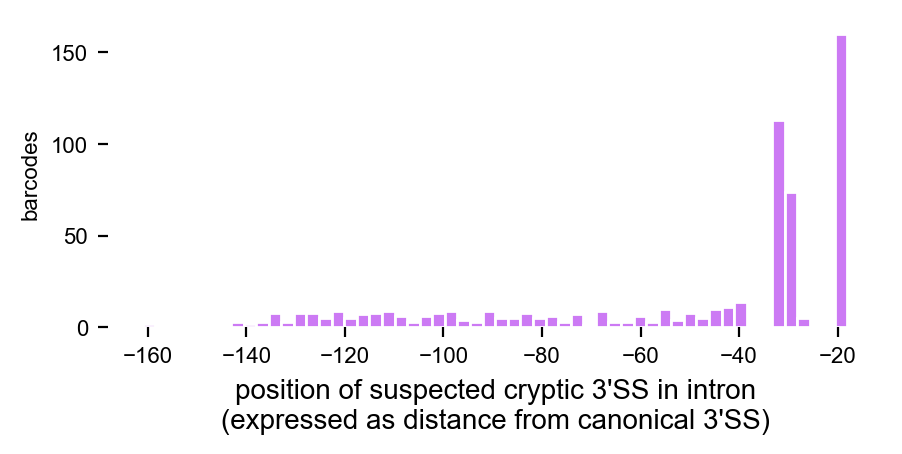

In [69]:
hist_data = [x[1] for bc,x in potential_alt_3ss_seqs_and_scores.items()]
plt.figure(figsize=(5,2))
plt.hist(hist_data, bins=56, 
         edgecolor='w', facecolor=nicecolors(4))
plt.xlabel('position of suspected cryptic 3\'SS in intron\n(expressed as distance from canonical 3\'SS)', fontsize=10)
plt.ylabel('barcodes')
plt.box(False)
plt.show()

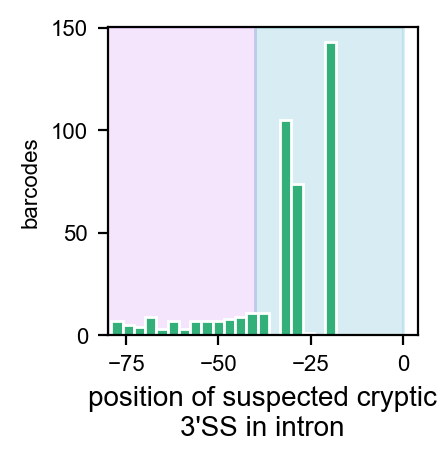

-19    139
-33    104
-29     70
-39     11
-45      5
Name: count, dtype: int64

In [175]:
hist_data = [x[1] for bc,x in potential_alt_3ss_seqs_and_scores.items() if (x[1]>-80)]
plt.figure(figsize=(2,2))
plt.axvspan(xmin=-90,xmax=-40,alpha=0.2, color=nicecolors(4), label='random region')
plt.axvspan(xmin=-40,xmax=0,alpha=0.2, color=nicecolors(3), label='constant BP, PPT & 3\'SS')
plt.hist(hist_data,bins=20,
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('position of suspected cryptic\n3\'SS in intron', fontsize=10)
plt.ylabel('barcodes')
plt.xlim(-80, 4)
#plt.title('what fraction of REVERSE unspliced reads\nare as expected for each barcode?')
plt.show()
vcs(hist_data)[:5]

In [176]:
print('      *   *         *')
print(threeSS_seq)

      *   *         *
GCCTCAGACAGTGGTTCAAAGTTTTTTTCTTCCATTTCAG


In [177]:
potential_cryptic_3ss_bcs = [bc for bc,(x,y,z) in potential_alt_3ss_seqs_and_scores.items()]
potential_cryptic_3ss = [x for x,y,z in potential_alt_3ss_seqs_and_scores.values()]
potential_cryptic_3ss_193 = [x for x,y,z in potential_alt_3ss_seqs_and_scores.values() if (y==-19)]
potential_cryptic_3ss_other = [x for x,y,z in potential_alt_3ss_seqs_and_scores.values() if (y!=-19)]

In [178]:
list_to_csv(potential_cryptic_3ss,outpath+'potential_cryptic_3ss_seqs.txt')

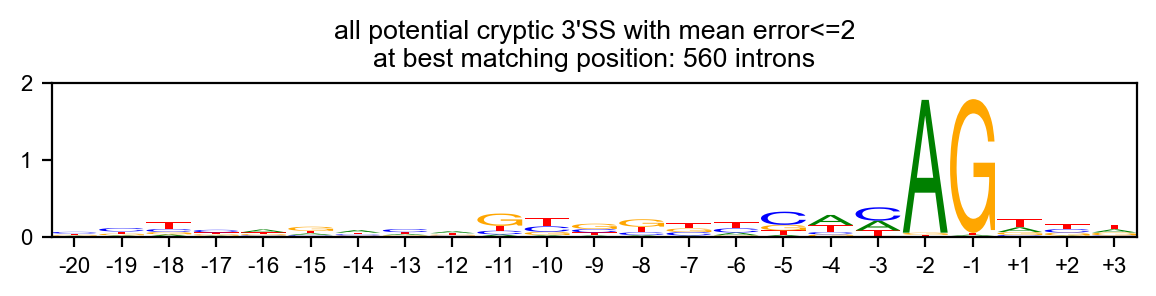

In [180]:
def set_3SS_xticks(ss_logo):
    ss_logo.ax.set_xticks(range(23))
    ss_logo.ax.set_xticklabels('%+d'%x for x in [-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,
                                                 -9,-8,-7,-6,-5,-4,-3,-2,-1, 1, 2, 3])
    ss_logo.ax.set_ylim(0,2)

SS_sets = [potential_cryptic_3ss,#potential_cryptic_3ss_193,potential_cryptic_3ss_other
          ]
SS_set_names = ['all potential cryptic 3\'SS with mean error<=2\nat best matching position',
                #'+193 3\'SS','other cryptic 3\'SSs'
               ]

for setname, SS_set in zip(SS_set_names,SS_sets):
    ss_logo = logomaker.Logo(sequences_to_df([x for x in SS_set if len(x)>0]),
                            figsize=(7,1))
    set_3SS_xticks(ss_logo)
    ss_logo.ax.set_title(f'{setname}: {len(SS_set)} introns')

# now I will make heatmap

In [182]:
read_types = ['both ends correct','5\'end incorrect','3\'end incorrect','both ends mismatch']
bc_read_type_counts = {b:{rt:0 for rt in read_types} for b in RIL2_unspliced}

for bc, dlist in RIL2_unspliced_dists.items():
    dlist = np.array(dlist)
    ok5 = dlist[:,0] <= tol5
    ok3 = dlist[:,1] <= tol3
    mm5 = dlist[:,0] > tol5
    mm3 = dlist[:,1] > tol3
    bc_read_type_counts[bc][read_types[0]] = (ok3&ok5).sum()
    bc_read_type_counts[bc][read_types[1]] = (ok3&mm5).sum()
    bc_read_type_counts[bc][read_types[2]] = (mm3&ok5).sum()
    bc_read_type_counts[bc][read_types[3]] = (mm3&mm5).sum()

# Convert the nested dictionary into a DataFrame
df = pd.DataFrame(bc_read_type_counts).T

# Normalize the data by row
df_normalized = df.div(df.sum(axis=1), axis=0)

In [183]:
potential_cryptic_3ss_bcs_in_const = [bc for bc,(x,y,z) in potential_alt_3ss_seqs_and_scores.items() if (y>=-40)]
potential_cryptic_5ss_bcs_in_const = [bc for bc,(x,y,z) in potential_alt_5ss_seqs_and_scores.items() if (y<=12)]

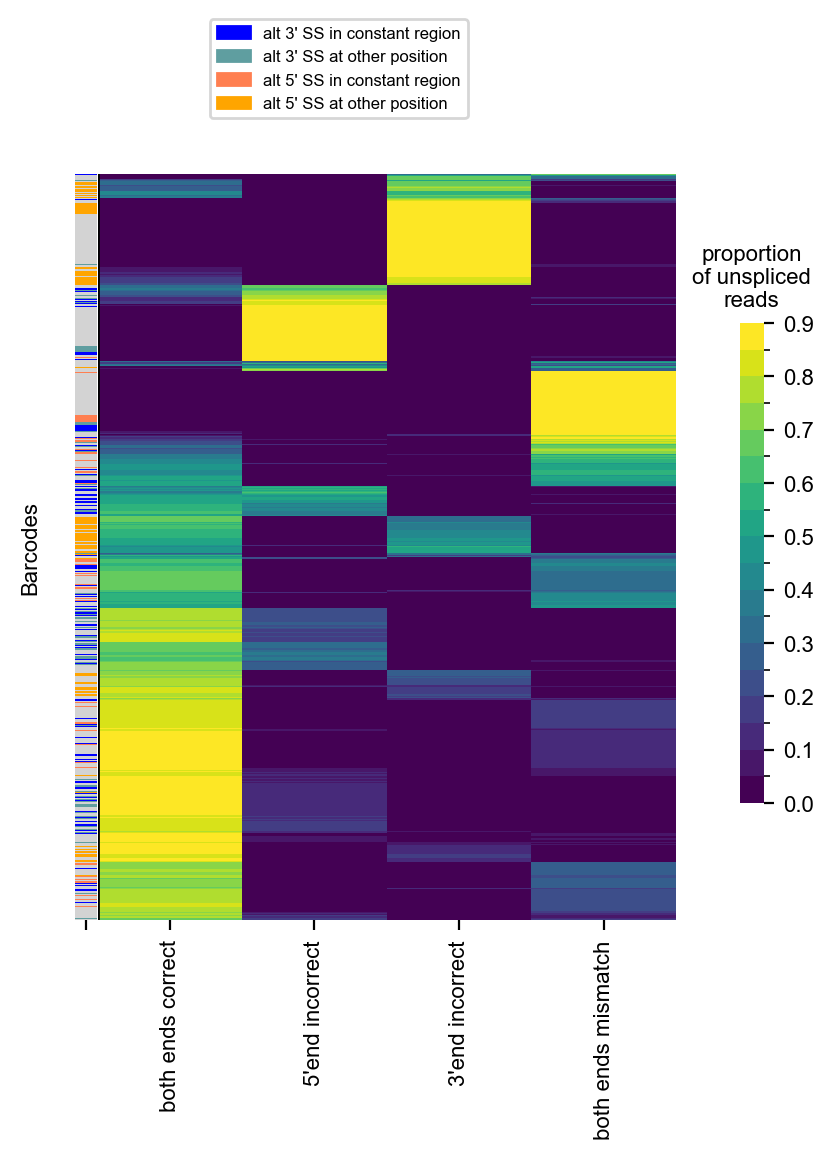

1808


In [188]:
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# We only need proportions for clustering and heatmap
heatmap_data = df_normalized[df_normalized['both ends correct']<0.9]
#heatmap_data = heatmap_data_1[heatmap_data_1.index.isin(potential_cryptic_3ss_bcs+potential_cryptic_5ss_bcs)]

# Define the number of bins and create a discrete colormap
n_bins = 18
cmap = plt.get_cmap('viridis', n_bins)
bounds = np.linspace(0, 0.9, n_bins + 1)  # create bounds for your data
norm = colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds

color_list = ['blue','cadetblue','coral', 'orange', 'orchid']
# Label barcodes by cryptic SS
color_map = {}
for bc in heatmap_data.index:
    #if bc in potential_cryptic_3ss_bcs and bc in potential_cryptic_5ss_bcs:
    #    color_map[bc] = color_list[4]
    if bc in potential_cryptic_3ss_bcs_in_const:
        color_map[bc] = color_list[0]
    elif bc in potential_cryptic_5ss_bcs_in_const:
        color_map[bc] = color_list[2]
    elif bc in potential_cryptic_3ss_bcs:
        color_map[bc] = color_list[1]
    elif bc in potential_cryptic_5ss_bcs:
        color_map[bc] = color_list[3]
    else:
        color_map[bc] = 'lightgrey'

row_colors = pd.Series(color_map, index=heatmap_data.index)

# Sort heatmap_data by row_colors to group barcodes by color
sorted_indices = row_colors.sort_values().index
sorted_heatmap_data = heatmap_data.loc[sorted_indices]
sorted_row_colors = row_colors.loc[sorted_indices]

# Create a clustermap with the discrete colormap
cg = sns.clustermap(sorted_heatmap_data, method='complete', cmap=cmap, norm=norm, figsize=(4, 6),
                    row_cluster=True, col_cluster=False,
                    col_colors=None,
                    yticklabels=False, xticklabels=True,
                    cbar_pos=(1.05, 0.3, 0.03, 0.4),    # x, y, width, height
                    row_colors=sorted_row_colors.iloc[cg.dendrogram_row.reordered_ind],
                    #linewidths=1,linecolor='k'
                   )

# Determine the width of the row_colors bars
divider = cg.ax_heatmap.get_xlim()[0] # You might need to adjust this value

# Draw a vertical black line at the right of the row_colors
cg.ax_heatmap.axvline(x=divider, color='black', linewidth=1)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), fontsize=8)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Barcodes\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('proportion\nof unspliced\nreads', fontsize=8)

# Define the legend for the row colors
handle_list = [mpatches.Patch(color=color_list[0], label='alt 3\' SS in constant region'),
               mpatches.Patch(color=color_list[1], label='alt 3\' SS at other position'),
               mpatches.Patch(color=color_list[2], label='alt 5\' SS in constant region'),
               mpatches.Patch(color=color_list[3], label='alt 5\' SS at other position'),
               #mpatches.Patch(color=color_list[4], label='alt 3\' SS AND 5\' SS??')
              ]

# Create the legend
plt.legend(handles=handle_list, bbox_to_anchor=(-11, 1.65), 
           fontsize=6)

plt.show()

print(len(sorted_heatmap_data))

In [189]:
#heatmap_data = df_normalized[df_normalized['both ends correct']<0.9]
#heatmap_data = df_normalized[df_normalized.index.isin(potential_cryptic_3ss_bcs+potential_cryptic_5ss_bcs)]
heatmap_data_cryptic = heatmap_data[heatmap_data.index.isin(potential_cryptic_3ss_bcs+potential_cryptic_5ss_bcs)]
heatmap_data_noncryptic = heatmap_data[~heatmap_data.index.isin(potential_cryptic_3ss_bcs+potential_cryptic_5ss_bcs)]

len(heatmap_data_cryptic)

713

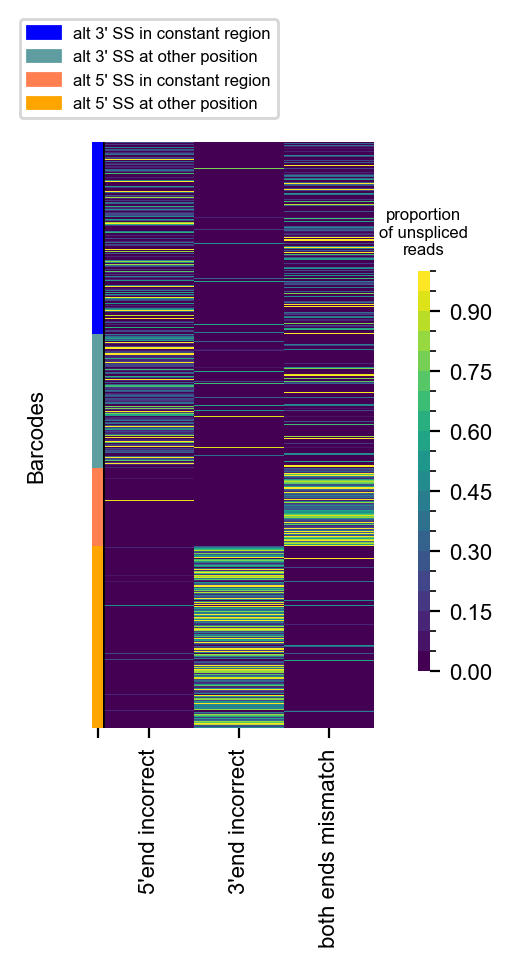

713


In [209]:
# We only need proportions for clustering and heatmap
heatmap_data = heatmap_data_cryptic

# Define the number of bins and create a discrete colormap
n_bins = 20
cmap = plt.get_cmap('viridis', n_bins)
bounds = np.linspace(0, 1, n_bins+1)  # create bounds for your data
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds

color_list = ['blue','cadetblue','coral', 'orange', 'orchid']

# Label barcodes by cryptic SS
color_map = {}
for bc in heatmap_data.index:
    if bc in potential_cryptic_3ss_bcs_in_const:
        color_map[bc] = color_list[0]
    elif bc in potential_cryptic_5ss_bcs_in_const:
        color_map[bc] = color_list[2]
    elif bc in potential_cryptic_3ss_bcs:
        color_map[bc] = color_list[1]
    elif bc in potential_cryptic_5ss_bcs:
        color_map[bc] = color_list[3]

row_colors = pd.Series(color_map, index=heatmap_data.index)

# Sort heatmap_data by row_colors to group barcodes by color
sorted_indices = row_colors.sort_values().index
sorted_heatmap_data = heatmap_data.loc[sorted_indices]
sorted_row_colors = row_colors.loc[sorted_indices]

# Create a clustermap with the discrete colormap
cg = sns.clustermap(sorted_heatmap_data.iloc[:,1:], method='complete', cmap=cmap, norm=norm, figsize=(2, 5),
                    row_cluster=False, col_cluster=False,
                    col_colors=None,
                    yticklabels=False, xticklabels=True,
                    cbar_pos=(1.05, 0.3, 0.03, 0.4),    # x, y, width, height
                    row_colors=sorted_row_colors,
                    
                    #linewidths=1,linecolor='k'
                   )

# Determine the width of the row_colors bars
divider = cg.ax_heatmap.get_xlim()[0] # You might need to adjust this value

# Draw a vertical black line at the right of the row_colors
cg.ax_heatmap.axvline(x=divider, color='black', linewidth=1)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), fontsize=8)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Barcodes\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('proportion\nof unspliced\nreads', fontsize=6)

# Define the legend for the row colors
handle_list = [mpatches.Patch(color=color_list[0], label='alt 3\' SS in constant region'),
               mpatches.Patch(color=color_list[1], label='alt 3\' SS at other position'),
               mpatches.Patch(color=color_list[2], label='alt 5\' SS in constant region'),
               mpatches.Patch(color=color_list[3], label='alt 5\' SS at other position'),
               #mpatches.Patch(color=color_list[4], label='alt 3\' SS AND 5\' SS??')
              ]

# Create the legend
plt.legend(handles=handle_list, bbox_to_anchor=(-11, 1.65), 
           fontsize=6)

plt.show()

print(len(sorted_heatmap_data))

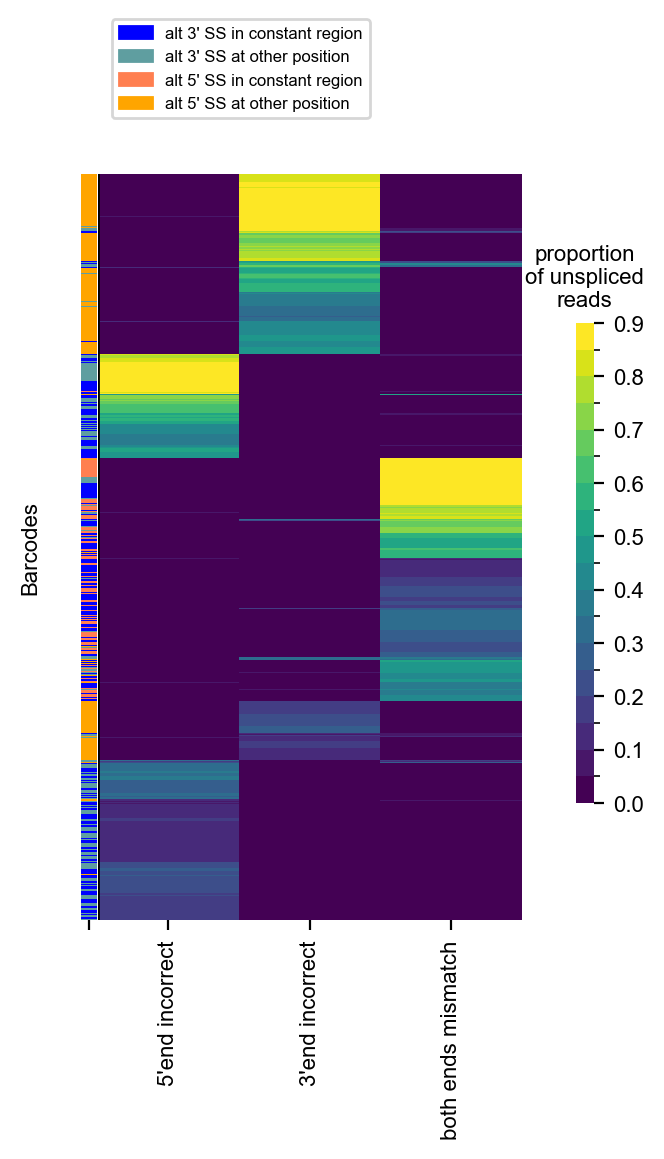

713


In [206]:
heatmap_data = heatmap_data_cryptic

# Define the number of bins and create a discrete colormap
n_bins = 18
cmap = plt.get_cmap('viridis', n_bins)
bounds = np.linspace(0, 0.9, n_bins + 1)  # create bounds for your data
norm = colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds

color_list = ['blue','cadetblue','coral', 'orange', 'orchid']
# Label barcodes by cryptic SS
color_map = {}
for bc in heatmap_data.index:
    #if bc in potential_cryptic_3ss_bcs and bc in potential_cryptic_5ss_bcs:
    #    color_map[bc] = color_list[4]
    if bc in potential_cryptic_3ss_bcs_in_const:
        color_map[bc] = color_list[0]
    elif bc in potential_cryptic_5ss_bcs_in_const:
        color_map[bc] = color_list[2]
    elif bc in potential_cryptic_3ss_bcs:
        color_map[bc] = color_list[1]
    elif bc in potential_cryptic_5ss_bcs:
        color_map[bc] = color_list[3]
    else:
        color_map[bc] = 'lightgrey'

row_colors = pd.Series(color_map, index=heatmap_data.index)

# Sort heatmap_data by row_colors to group barcodes by color
sorted_indices = row_colors.sort_values().index
sorted_heatmap_data = heatmap_data.loc[sorted_indices]
sorted_row_colors = row_colors.loc[sorted_indices]

# Create a clustermap with the discrete colormap
cg = sns.clustermap(sorted_heatmap_data.iloc[:,1:], method='complete', cmap=cmap, norm=norm, figsize=(3, 6),
                    row_cluster=True, col_cluster=False,
                    col_colors=None,
                    yticklabels=False, xticklabels=True,
                    cbar_pos=(1.05, 0.3, 0.03, 0.4),    # x, y, width, height
                    row_colors=sorted_row_colors.iloc[cg.dendrogram_row.reordered_ind],
                    #linewidths=1,linecolor='k'
                   )

# Determine the width of the row_colors bars
divider = cg.ax_heatmap.get_xlim()[0] # You might need to adjust this value

# Draw a vertical black line at the right of the row_colors
cg.ax_heatmap.axvline(x=divider, color='black', linewidth=1)

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), fontsize=8)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Barcodes\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('proportion\nof unspliced\nreads', fontsize=8)

# Define the legend for the row colors
handle_list = [mpatches.Patch(color=color_list[0], label='alt 3\' SS in constant region'),
               mpatches.Patch(color=color_list[1], label='alt 3\' SS at other position'),
               mpatches.Patch(color=color_list[2], label='alt 5\' SS in constant region'),
               mpatches.Patch(color=color_list[3], label='alt 5\' SS at other position'),
               #mpatches.Patch(color=color_list[4], label='alt 3\' SS AND 5\' SS??')
              ]

# Create the legend
plt.legend(handles=handle_list, bbox_to_anchor=(-11, 1.65), 
           fontsize=6)

plt.show()

print(len(sorted_heatmap_data))

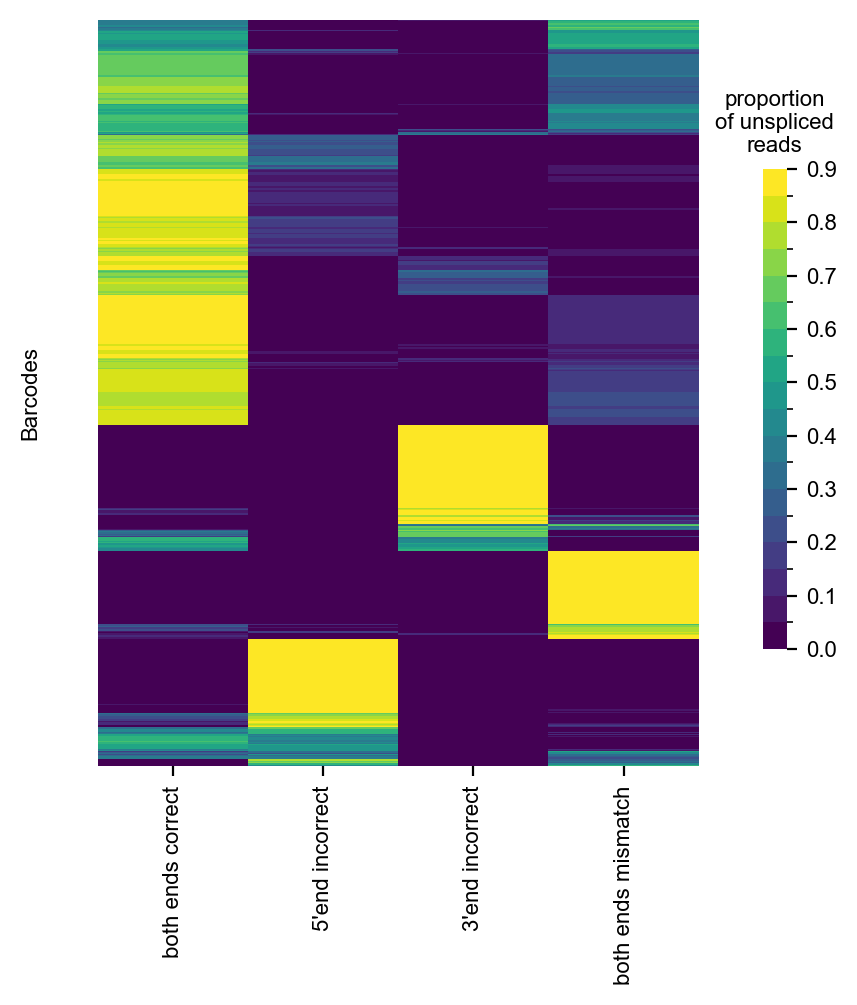

In [194]:
heatmap_data = heatmap_data_noncryptic

# Create a clustermap with the discrete colormap
cg = sns.clustermap(heatmap_data, method='ward', cmap=cmap, norm=norm, figsize=(4, 6),
                    row_cluster=True, col_cluster=False,
                    col_colors=None,
                    yticklabels=False, xticklabels=True,
                    cbar_pos=(1.05, 0.3, 0.03, 0.4))

cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), fontsize=8)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Barcodes\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('proportion\nof unspliced\nreads', fontsize=8)

plt.show()

249679


/Users/emmakowal/miniconda3/envs/random_IME_screens_meta_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2400x2000 with 0 Axes>

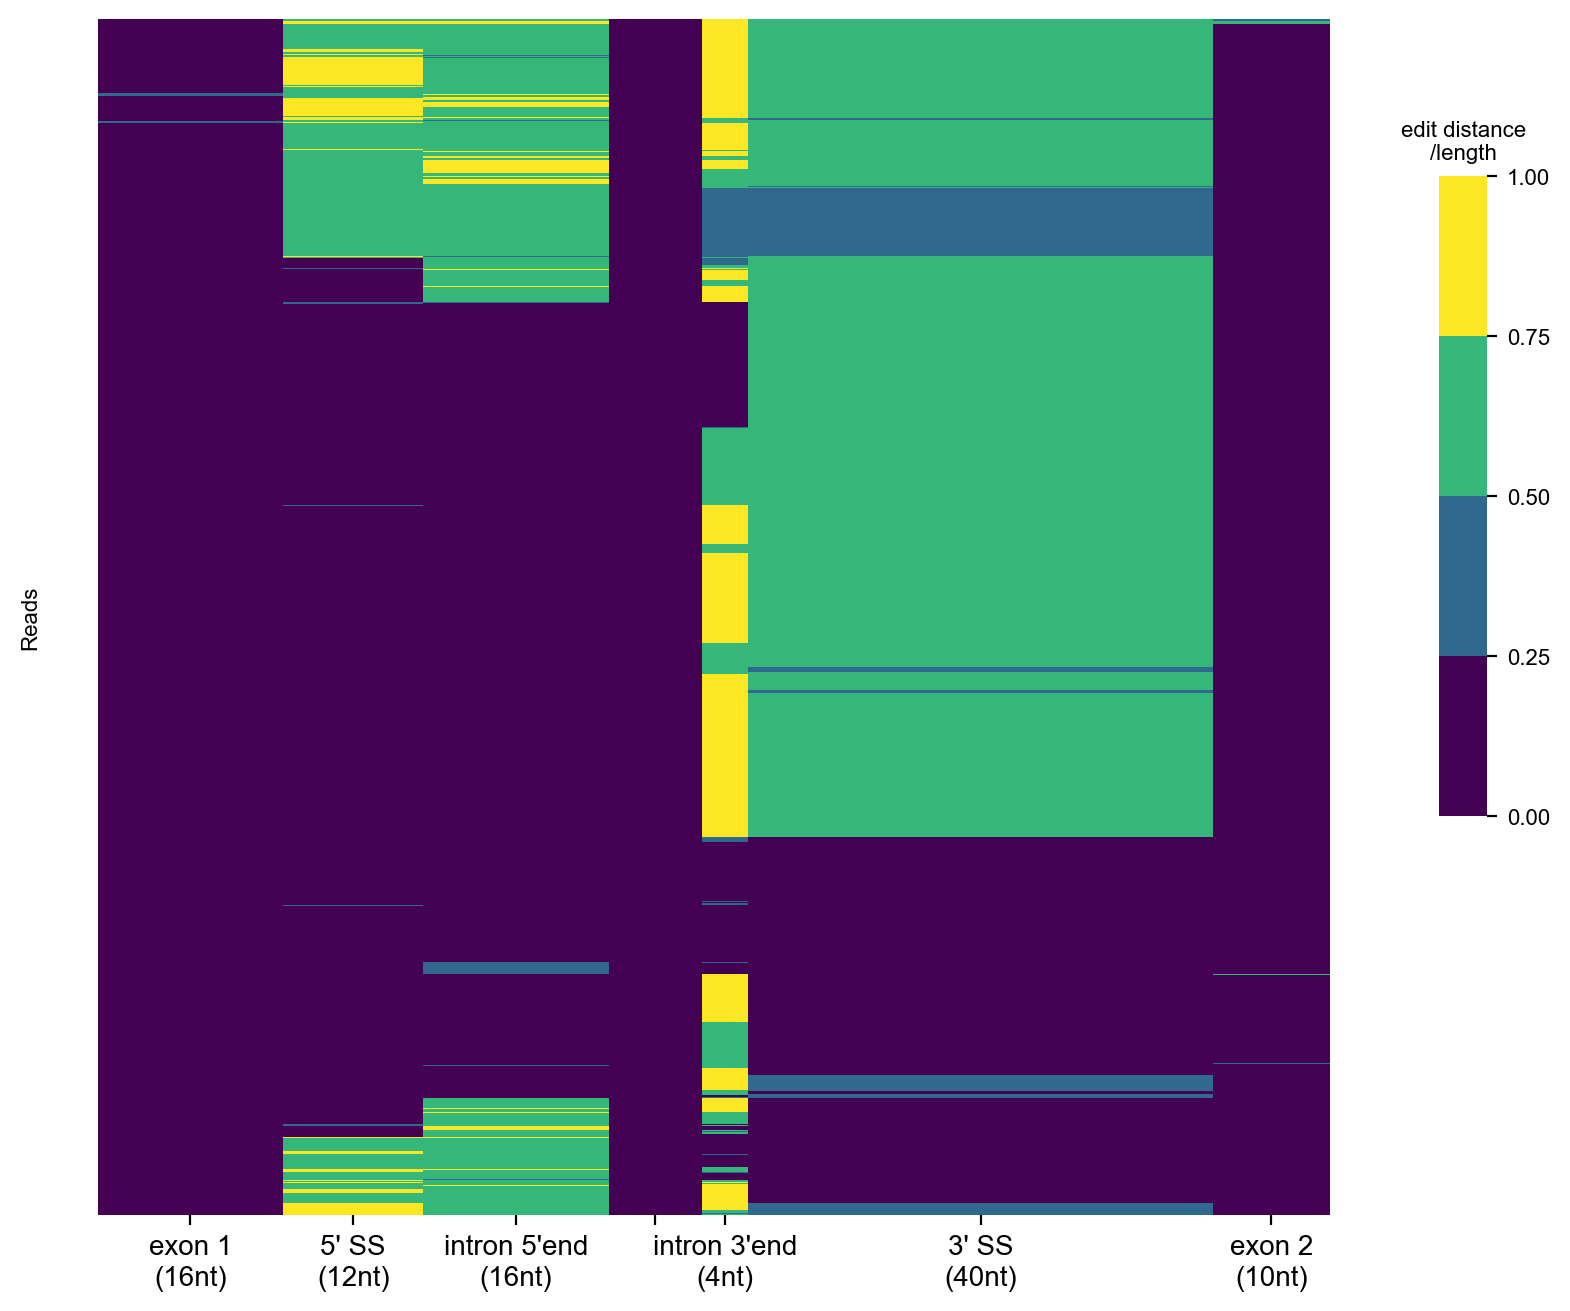

In [195]:
all_unexplained_vectors = flatten([x for b,x in RIL2_unspliced_errors.items() if b in heatmap_data.index]) 
all_unexp_nonzero_vectors = np.array(all_unexplained_vectors)[np.array(all_unexplained_vectors).sum(1)!=0]
print(len(all_unexp_nonzero_vectors))

lengths = [16, 12, 16, 4, 40, 10]
unexp_nonzero_norm_vectors = all_unexp_nonzero_vectors/np.array(lengths)
unexp_expanded_vectors = np.array([[val for val, count in zip(x, lengths) for _ in range(count)] for x in unexp_nonzero_norm_vectors])

spacer_length = 8
unexp_exp_vecs_w_spacer = np.concatenate([unexp_expanded_vectors[:,:(16+12+16)],
                                   np.zeros(((unexp_expanded_vectors.shape[0]),spacer_length)),
                                   unexp_expanded_vectors[:,(16+12+16):]], axis=1)

vecs = unexp_exp_vecs_w_spacer
row_indices = np.random.choice(vecs.shape[0], size=8000, replace=False)
vectors_to_plot = vecs[row_indices, :]

df = pd.DataFrame(vectors_to_plot)
#df.columns = RIL2_unspliced_vectors.keys()
#df.columns = [f'Position {i+1}' for i in range(6)]

#n_bins = 13
#cmap = plt.get_cmap('gnuplot2_r', n_bins)
#bounds = np.linspace(0, 26, n_bins + 1)  # create bounds for your data
#norm = colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds

n_bins = 4
cmap = plt.get_cmap('viridis', n_bins)
bounds = np.linspace(0, 1, n_bins + 1)  # create bounds for your data
norm = colors.BoundaryNorm(bounds, cmap.N)  # define a normalization based on these bounds


# Plotting the heatmap with hierarchical clustering
plt.figure(figsize=(12, 10))
cg = sns.clustermap(df, method='complete', metric='euclidean', figsize=(8,8), 
                   col_cluster=False, cmap=cmap, norm=norm,
                   cbar_pos=(1.05, 0.3, 0.03, 0.4),
                    yticklabels=False)

plt.title('Clustered Heatmap of Barcode Vectors')

lengths_w_spacer = [16, 12, 16, spacer_length, 4, 40, 10]
cg.ax_heatmap.set_xticks([(l/2)+np.sum(lengths_w_spacer[:i]) for i,l in enumerate(lengths_w_spacer)])
cg.ax_heatmap.set_xticklabels(['exon 1\n(16nt)', '5\' SS\n(12nt)',
                               'intron 5\'end\n(16nt)',
                               '',
                               'intron 3\'end\n(4nt)',
                               '3\' SS\n(40nt)', 
                               'exon 2\n(10nt)'], 
                              fontsize=10, rotation=0
                             )
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_ylabel('Reads\n\n')
cg.ax_heatmap.yaxis.set_label_position('left')
cg.cax.set_title('edit distance\n/length', fontsize=8)
cg.cax.set_yticks([0,0.25,0.5,0.75,1])

plt.show()

In [214]:
cryptic_lists = {'3': potential_cryptic_3ss_bcs,
                 '3c':potential_cryptic_3ss_bcs_in_const,
                 '5': potential_cryptic_5ss_bcs,
                 '5c':potential_cryptic_5ss_bcs_in_const}

with open(outpath+'pkls/cryptic_spliced_bc_lists.pkl', 'wb') as f:
    pickle.dump(cryptic_lists, f)

In [215]:
len(flatten(cryptic_lists.values()))

1418

In [216]:
len(set(flatten(cryptic_lists.values())))

932